# Analytics

#### Date: 2021/01

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/02
##### Professor: Hilmer Neri

##### Members:

- Caio César de Almeida Beleza
- João Victor Lustosa Braz 
- Lucas Lopes Xavier
- André Macedo Rodrigues Alves
- Arthur José Nascimento de Lima
- Cícero Barrozo Fernandes Filho
- Daniel Rocha Oliveira
- Gabriel de Souza Fonseca Ribeiro
- Matheus Raphael Soares de Oliveira	
- Pedro Victor Lima Torreão

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [4]:
jsons = glob('../analytics-raw-data/*.json') # add the path here

In [5]:
jsons

['../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-FrontEnd-04-01-2022-10-41-30-v3.1.0.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-Registros-04-01-2022-10-42-10-v4.6.0.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022-23-14-35-v3.0.7.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-Registros-03-26-2022-18-26-26-v4.5.2.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-18-59-14-v3.3.1.json']

In [6]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:
        
        if i.endswith("-test.json"):
            continue

        base_component = read_json(i)
        
        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)

    aux_df = df['filename'].str.split(r"Oraculo-(.*?)-*-(.*?).json", expand=True)

    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [7]:
base_component_df = create_base_component_df(jsons)

/tmp/ipykernel_261149/1488431555.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_261149/1488431555.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_261149/1488431555.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_261149/1488431555.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_261149/1488431555.py:25: FutureWarning: The frame.append method is deprec

In [8]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
18,duplicated_lines_density,2.4,False,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
19,functions,375,NaN,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
20,security_rating,1.0,True,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
21,files,109,NaN,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
22,complexity,525,NaN,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
23,ncloc,7026,NaN,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
24,coverage,13.9,False,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
25,reliability_rating,1.0,True,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
26,comment_lines_density,1.6,False,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,FrontEnd,03-25-2022-23-14-35-v3.0.7
0,duplicated_lines_density,2.9,False,fga-eps-mds-2021-2-Oraculo-FrontEnd-04-01-2022...,FrontEnd,04-01-2022-10-41-30-v3.1.0


#### Create dataframe per file

In [9]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [10]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')
        file_component_df_js = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')
        
        file_component_df['filename'] = os.path.basename(i)
        file_component_df_js['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        df = df.append(file_component_df_js, ignore_index=True)
          
    aux_df = df['filename'].str.split(r"Oraculo-(.*?)-*-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [11]:
file_component_df = create_file_df(jsons)

/tmp/ipykernel_261149/1690642286.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_261149/1690642286.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df_js, ignore_index=True)
/tmp/ipykernel_261149/1690642286.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_261149/1690642286.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df_js, ignore_index=True)
/tmp/ipykernel_261149/1690642286.py:47: FutureWarning: The frame.append method is 

In [12]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,test_errors,test_failures,repository,version
126,src/App.js,1,1,0.0,0.0,100.0,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,0,0,FrontEnd,03-25-2022-23-14-35-v3.0.7
127,src/App.test.js,3,3,0.0,0.0,0.0,13,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,0,0,FrontEnd,03-25-2022-23-14-35-v3.0.7
128,src/Auth/Auth.js,5,7,19.2,0.0,31.6,21,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,0,0,FrontEnd,03-25-2022-23-14-35-v3.0.7
129,src/Services/Axios/BaseService/baseService.js,6,7,0.0,0.0,23.1,52,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,0,0,FrontEnd,03-25-2022-23-14-35-v3.0.7
130,src/Constants/baseUrls.js,0,1,28.6,0.0,71.4,20,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,0,0,FrontEnd,03-25-2022-23-14-35-v3.0.7
131,src/Components/DropDownButton/DivSelectSetor.js,0,0,0.0,0.0,100.0,23,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,0,0,FrontEnd,03-25-2022-23-14-35-v3.0.7
132,src/Constants/federativeUnits.js,0,0,0.0,0.0,100.0,29,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,0,0,FrontEnd,03-25-2022-23-14-35-v3.0.7
133,src/history.js,0,0,0.0,0.0,100.0,3,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,0,0,FrontEnd,03-25-2022-23-14-35-v3.0.7
134,src/index.js,0,0,20.0,0.0,0.0,12,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,0,0,FrontEnd,03-25-2022-23-14-35-v3.0.7
135,src/Pages/EditRecord/index.js,25,40,0.9,0.0,1.0,321,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,0,0,FrontEnd,03-25-2022-23-14-35-v3.0.7


#### Create dataframe per repository

In [13]:
# Example

frontEnd_df = file_component_df[file_component_df['repository'] == 'FrontEnd']
profile_df = file_component_df[file_component_df['repository'] == 'Profile']
registros_df = file_component_df[file_component_df['repository'] == 'Registros']

In [14]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        ncloc += int(each)

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [15]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [16]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [17]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [18]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [19]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [20]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [21]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m4(version_df))
        m5_list.append(m5(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm5': m5_list,
                               'm6': m6_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [22]:
frontEnd_metrics = create_metrics_df(frontEnd_df)
profile_metrics = create_metrics_df(profile_df)
registros_metrics = create_metrics_df(registros_df)

### Data visualization

- You must do this for each of your repositories

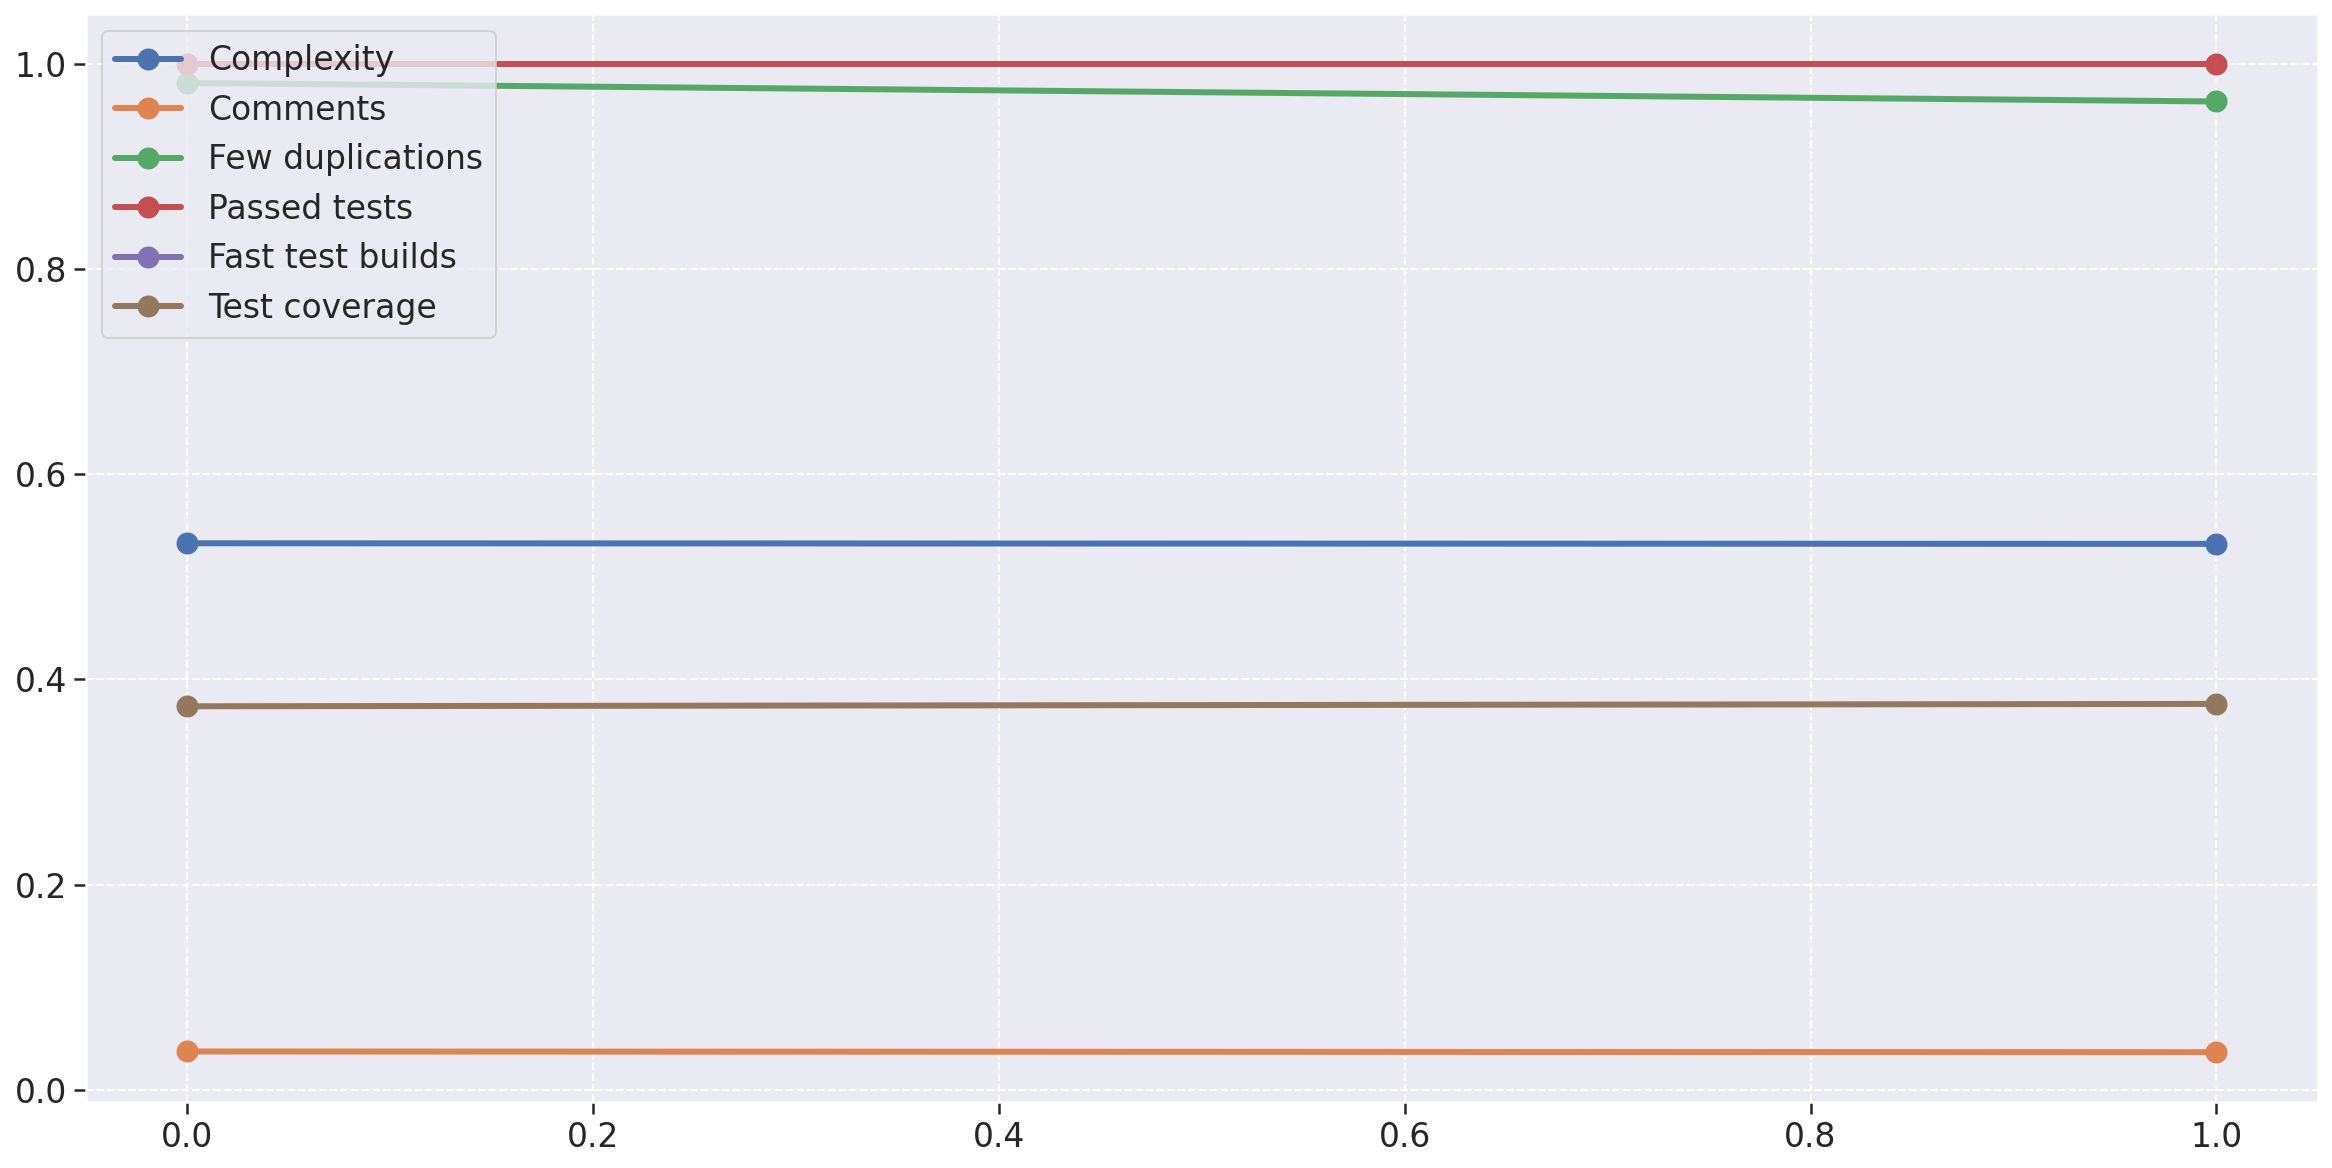

In [23]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontEnd_metrics['m1'], label='Complexity', linewidth=3, marker='o', markersize=10)
plt.plot(frontEnd_metrics['m2'], label='Comments', linewidth=3, marker='o', markersize=10)
plt.plot(frontEnd_metrics['m3'], label='Few duplications', linewidth=3, marker='o', markersize=10)
plt.plot(frontEnd_metrics['m4'], label='Passed tests', linewidth=3, marker='o', markersize=10)
plt.plot(frontEnd_metrics['m5'], label='Fast test builds', linewidth=3, marker='o', markersize=10)
plt.plot(frontEnd_metrics['m6'], label='Test coverage', linewidth=3, marker='o', markersize=10)

plt.legend(loc='upper left')

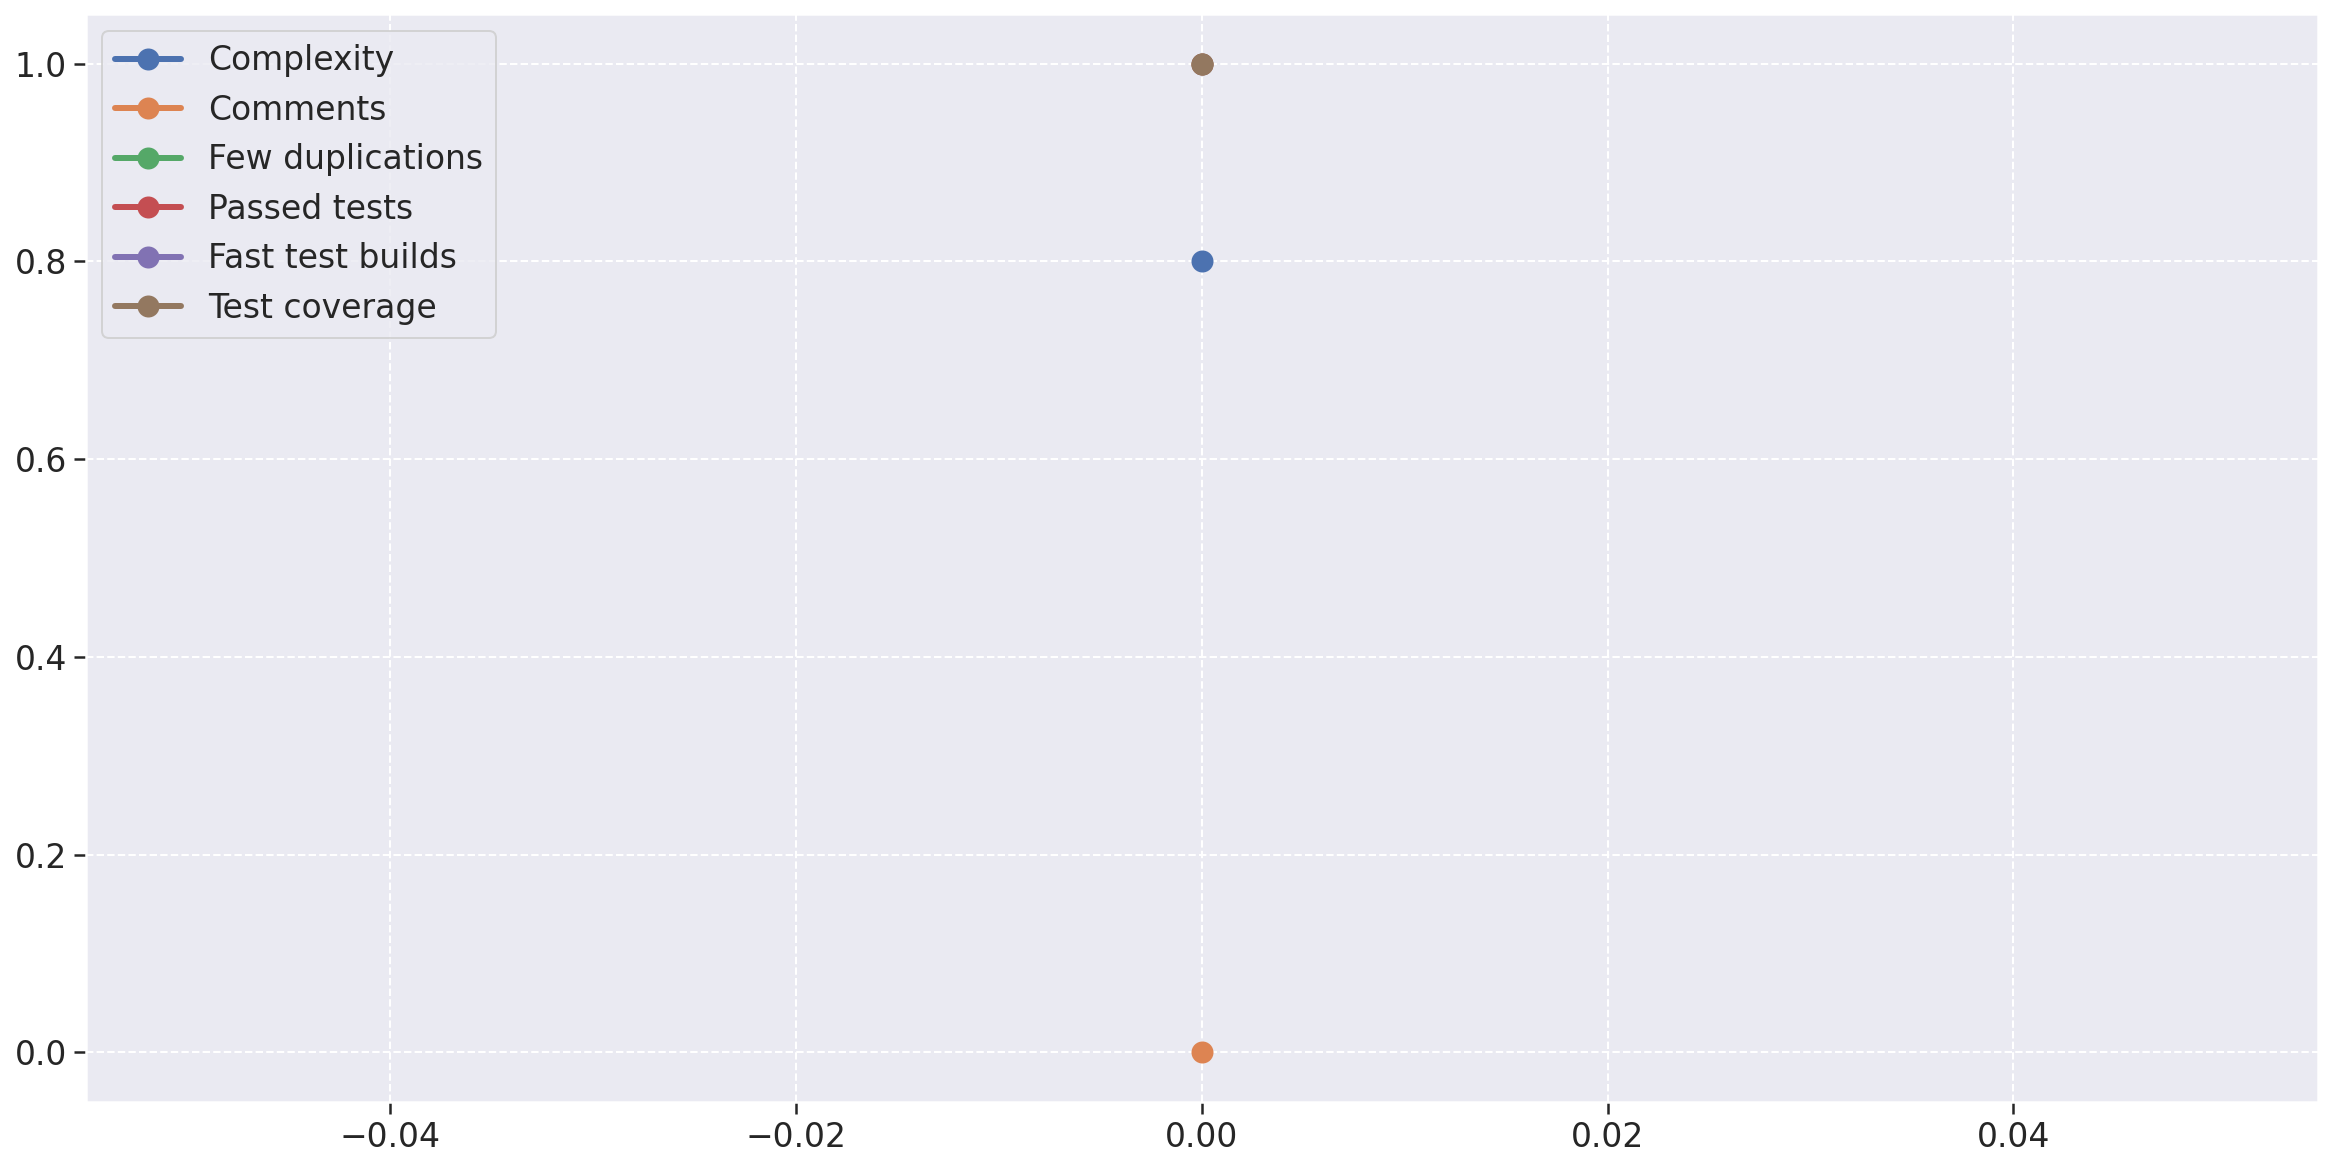

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.plot(profile_metrics['m1'], label='Complexity', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m2'], label='Comments', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m3'], label='Few duplications', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m4'], label='Passed tests', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m5'], label='Fast test builds', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m6'], label='Test coverage', linewidth=3, marker='o', markersize=10)

plt.legend(loc='upper left')

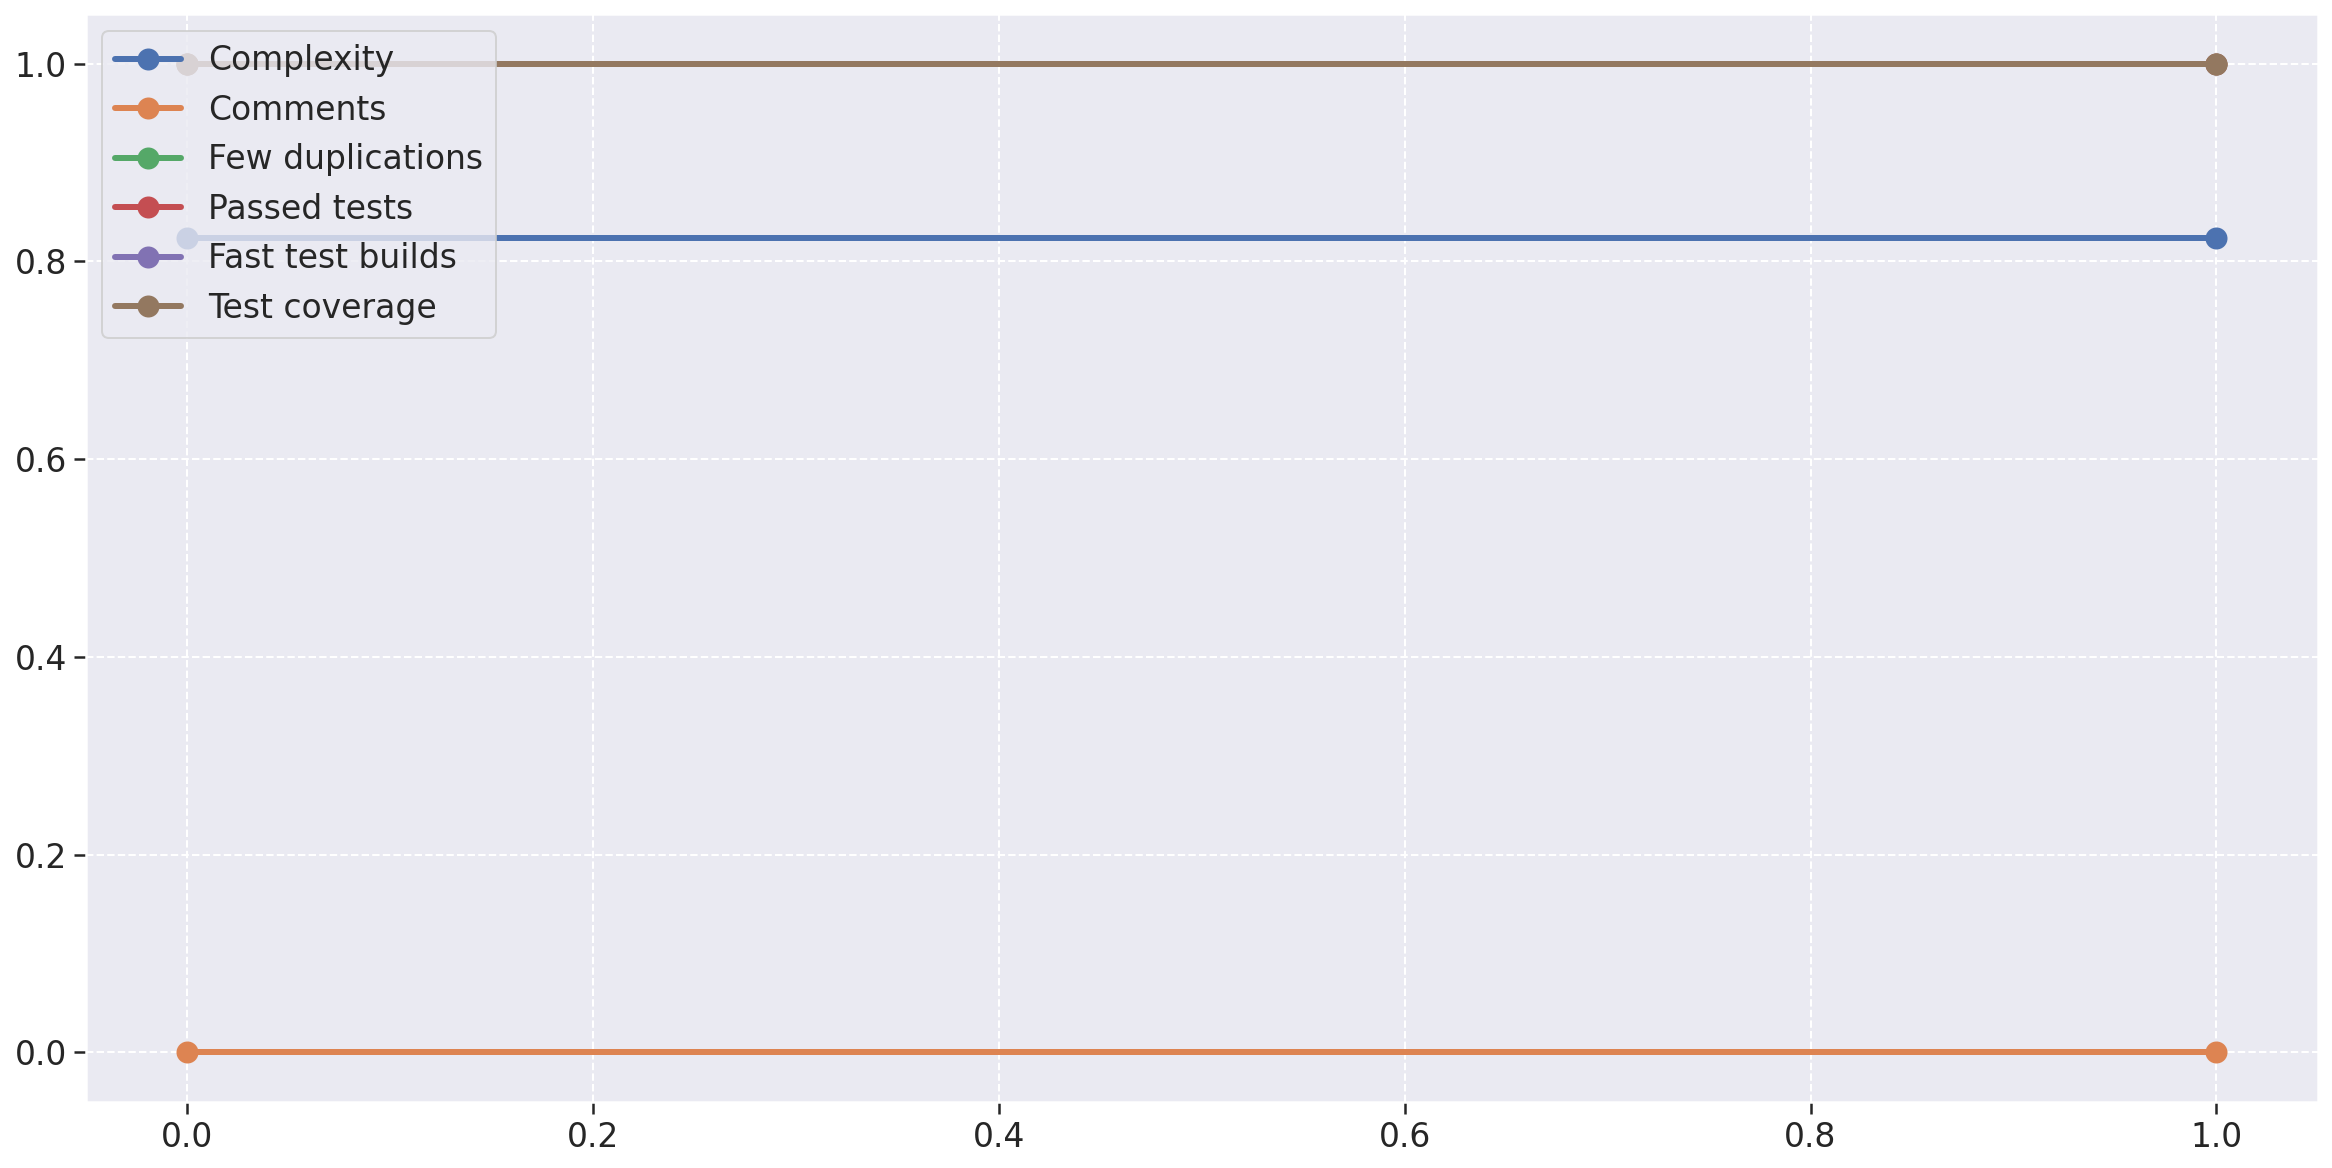

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.plot(registros_metrics['m1'], label='Complexity', linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m2'], label='Comments', linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m3'], label='Few duplications', linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m4'], label='Passed tests', linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m5'], label='Fast test builds', linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m6'], label='Test coverage', linewidth=3, marker='o', markersize=10)

plt.legend(loc='upper left')

### Sub characteristic aggregation

- You must do this for each of your repositories

In [26]:
psc1, psc2 = 1, 1
pc1, pc2 = 0.5, 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

frontEnd_metrics['code_quality'] = ((frontEnd_metrics['m1']*pm1) + (frontEnd_metrics['m2']*pm2) + (frontEnd_metrics['m3']*pm3)) * psc1
profile_metrics['code_quality'] = ((profile_metrics['m1']*pm1) + (profile_metrics['m2']*pm2) + (profile_metrics['m3']*pm3)) * psc1
registros_metrics['code_quality'] = ((registros_metrics['m1']*pm1) + (registros_metrics['m2']*pm2) + (registros_metrics['m3']*pm3)) * psc1

frontEnd_metrics['testing_status'] = ((frontEnd_metrics['m4']*pm4) + (frontEnd_metrics['m5']*pm5) + (frontEnd_metrics['m6']*pm6)) * psc2
profile_metrics['testing_status'] = ((profile_metrics['m4']*pm4) + (profile_metrics['m5']*pm5) + (profile_metrics['m6']*pm6)) * psc2
registros_metrics['testing_status'] = ((registros_metrics['m4']*pm4) + (registros_metrics['m5']*pm5) + (registros_metrics['m6']*pm6)) * psc2

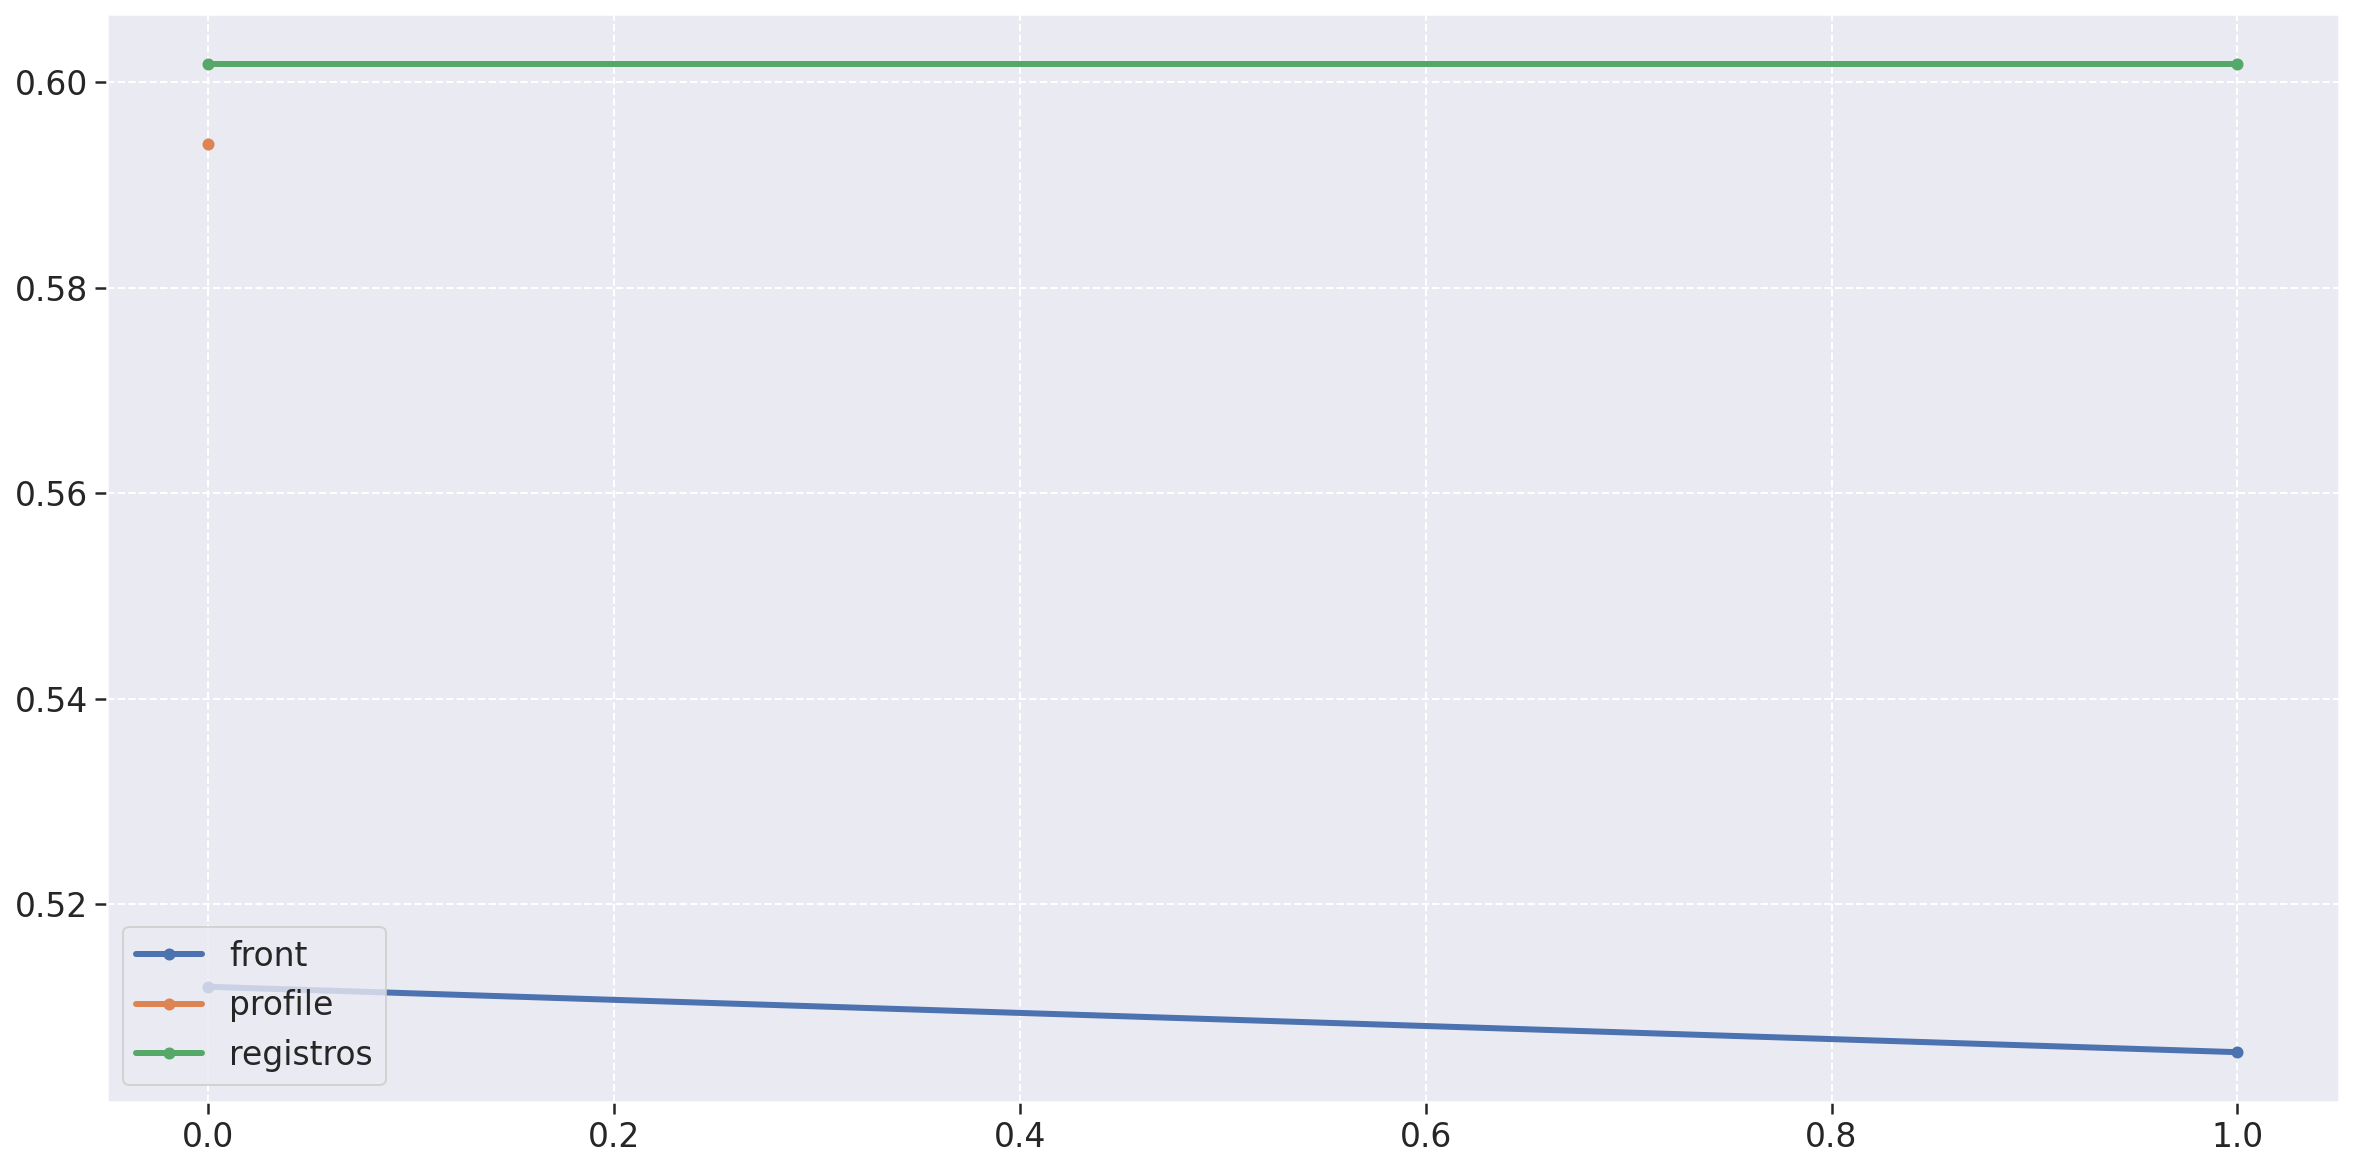

In [27]:
fig = plt.figure(figsize=(20, 10))


plt.plot(frontEnd_metrics['code_quality'], label='front', linewidth=3, marker='o', markersize=5)
plt.plot(profile_metrics['code_quality'], label='profile', linewidth=3, marker='o', markersize=5)
plt.plot(registros_metrics['code_quality'], label='registros', linewidth=3, marker='o', markersize=5)

plt.legend(loc='lower left')

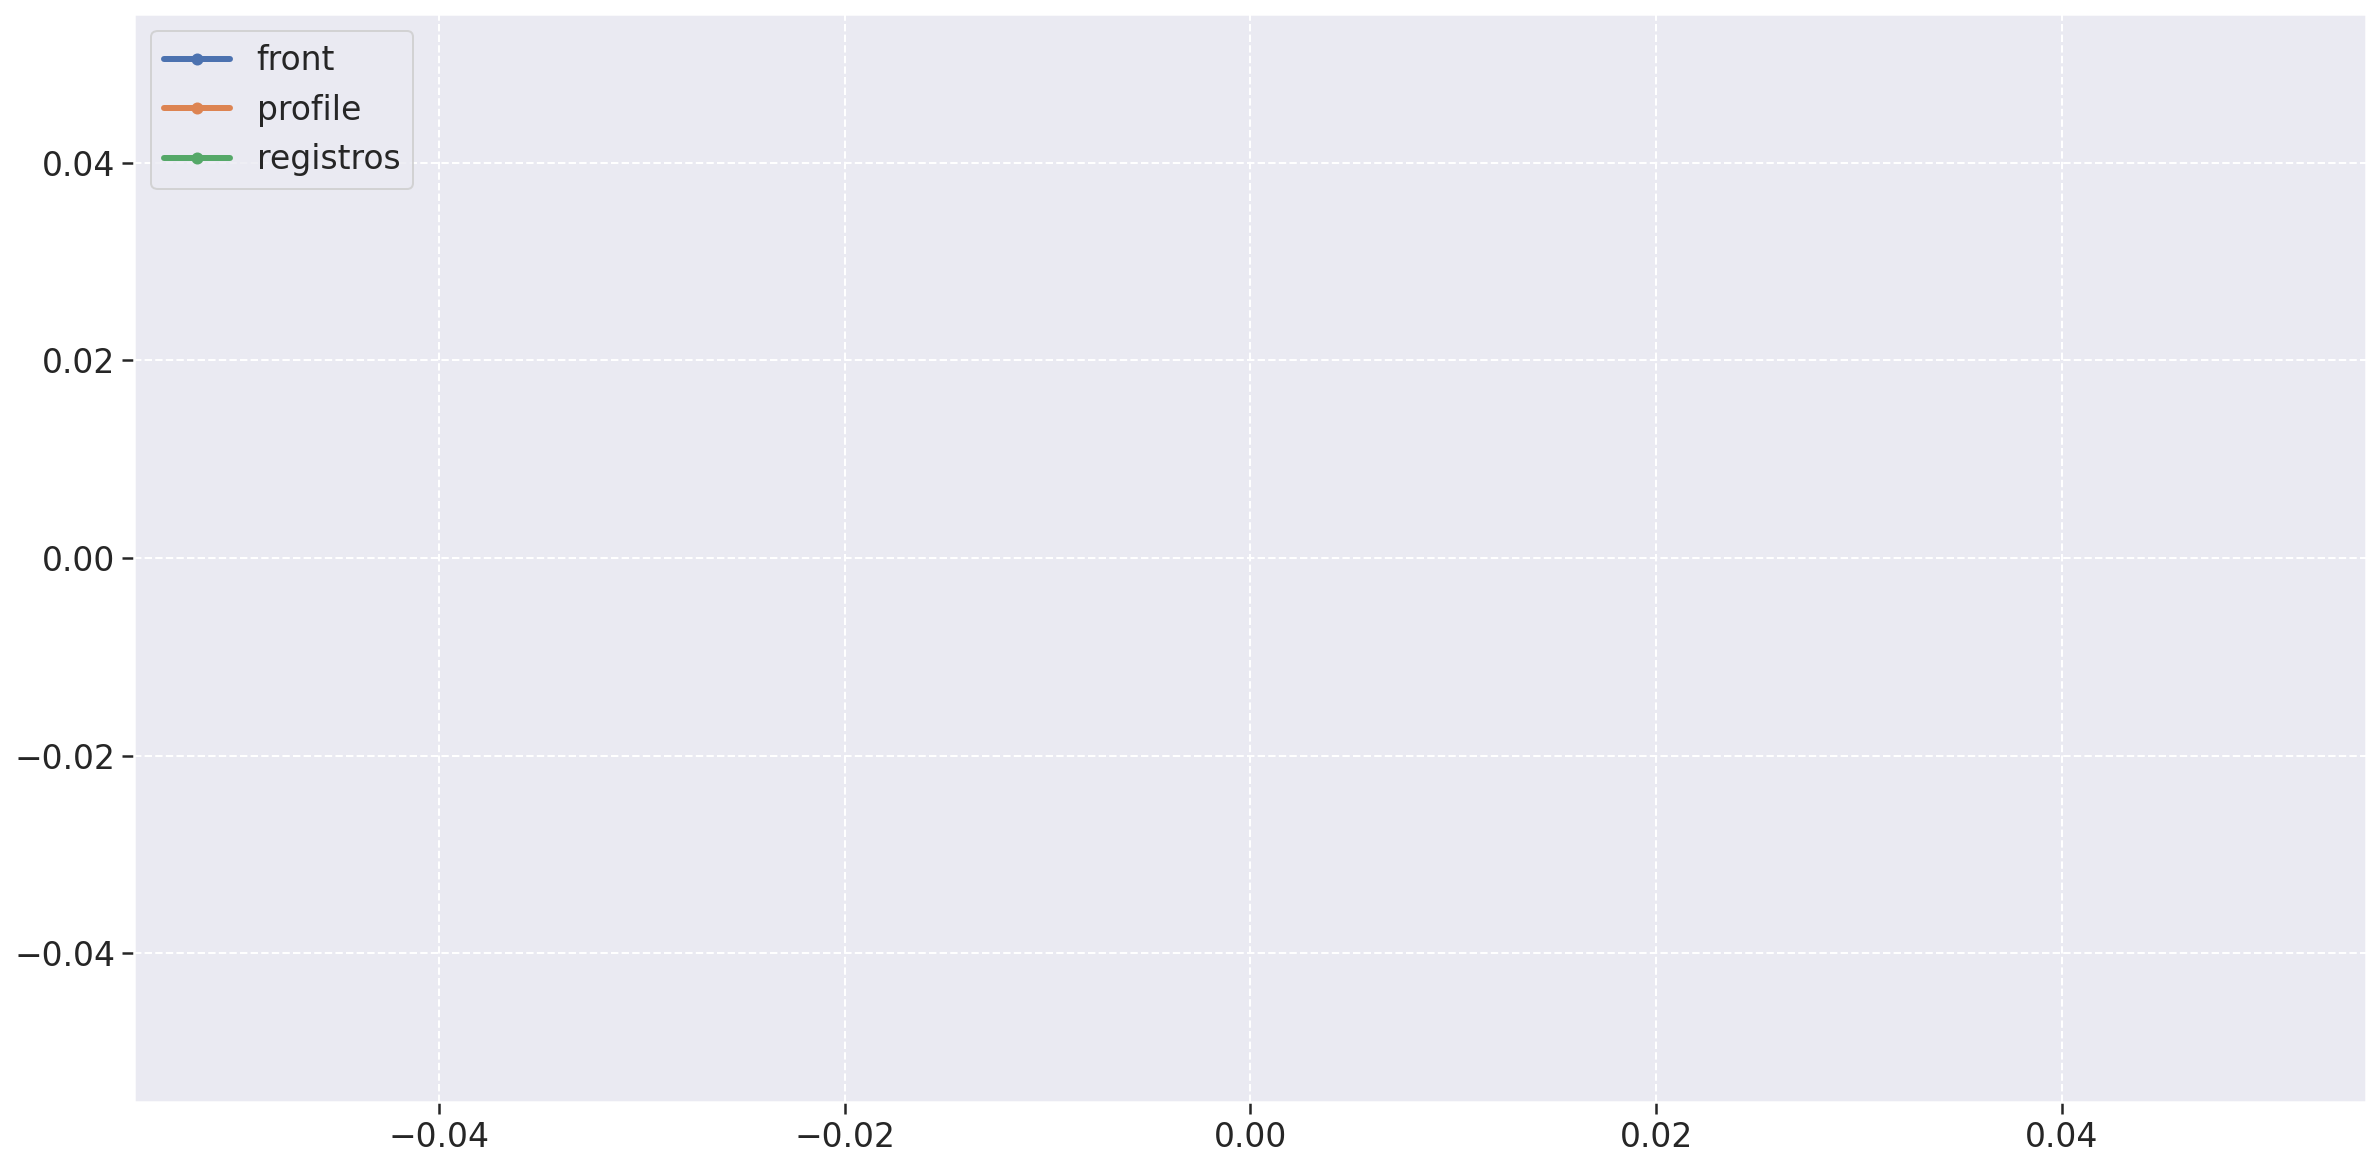

In [28]:
fig = plt.figure(figsize=(20, 10))


plt.plot(frontEnd_metrics['testing_status'], label='front', linewidth=3, marker='o', markersize=5)
plt.plot(profile_metrics['testing_status'], label='profile', linewidth=3, marker='o', markersize=5)
plt.plot(registros_metrics['testing_status'], label='registros', linewidth=3, marker='o', markersize=5)

plt.legend(loc='upper left')

In [29]:
metrics_df = pd.concat([
frontEnd_metrics,
profile_metrics,
registros_metrics
], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

In [30]:
metrics_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,maintainability,Reliability,total
0,0.532710,0.037383,0.981308,1.0,NaN,0.373832,FrontEnd,03-25-2022-23-14-35-v3.0.7,6981,0.511963,NaN,0.255981,NaN,NaN
1,0.532110,0.036697,0.963303,1.0,NaN,0.376147,FrontEnd,04-01-2022-10-41-30-v3.1.0,7144,0.505596,NaN,0.252798,NaN,NaN
2,0.800000,0.000000,1.000000,1.0,NaN,1.000000,Profile,03-27-2022-18-59-14-v3.3.1,479,0.594000,NaN,0.297000,NaN,NaN
3,0.823529,0.000000,1.000000,1.0,NaN,1.000000,Registros,03-26-2022-18-26-26-v4.5.2,978,0.601765,NaN,0.300882,NaN,NaN
4,0.823529,0.000000,1.000000,1.0,NaN,1.000000,Registros,04-01-2022-10-42-10-v4.6.0,984,0.601765,NaN,0.300882,NaN,NaN


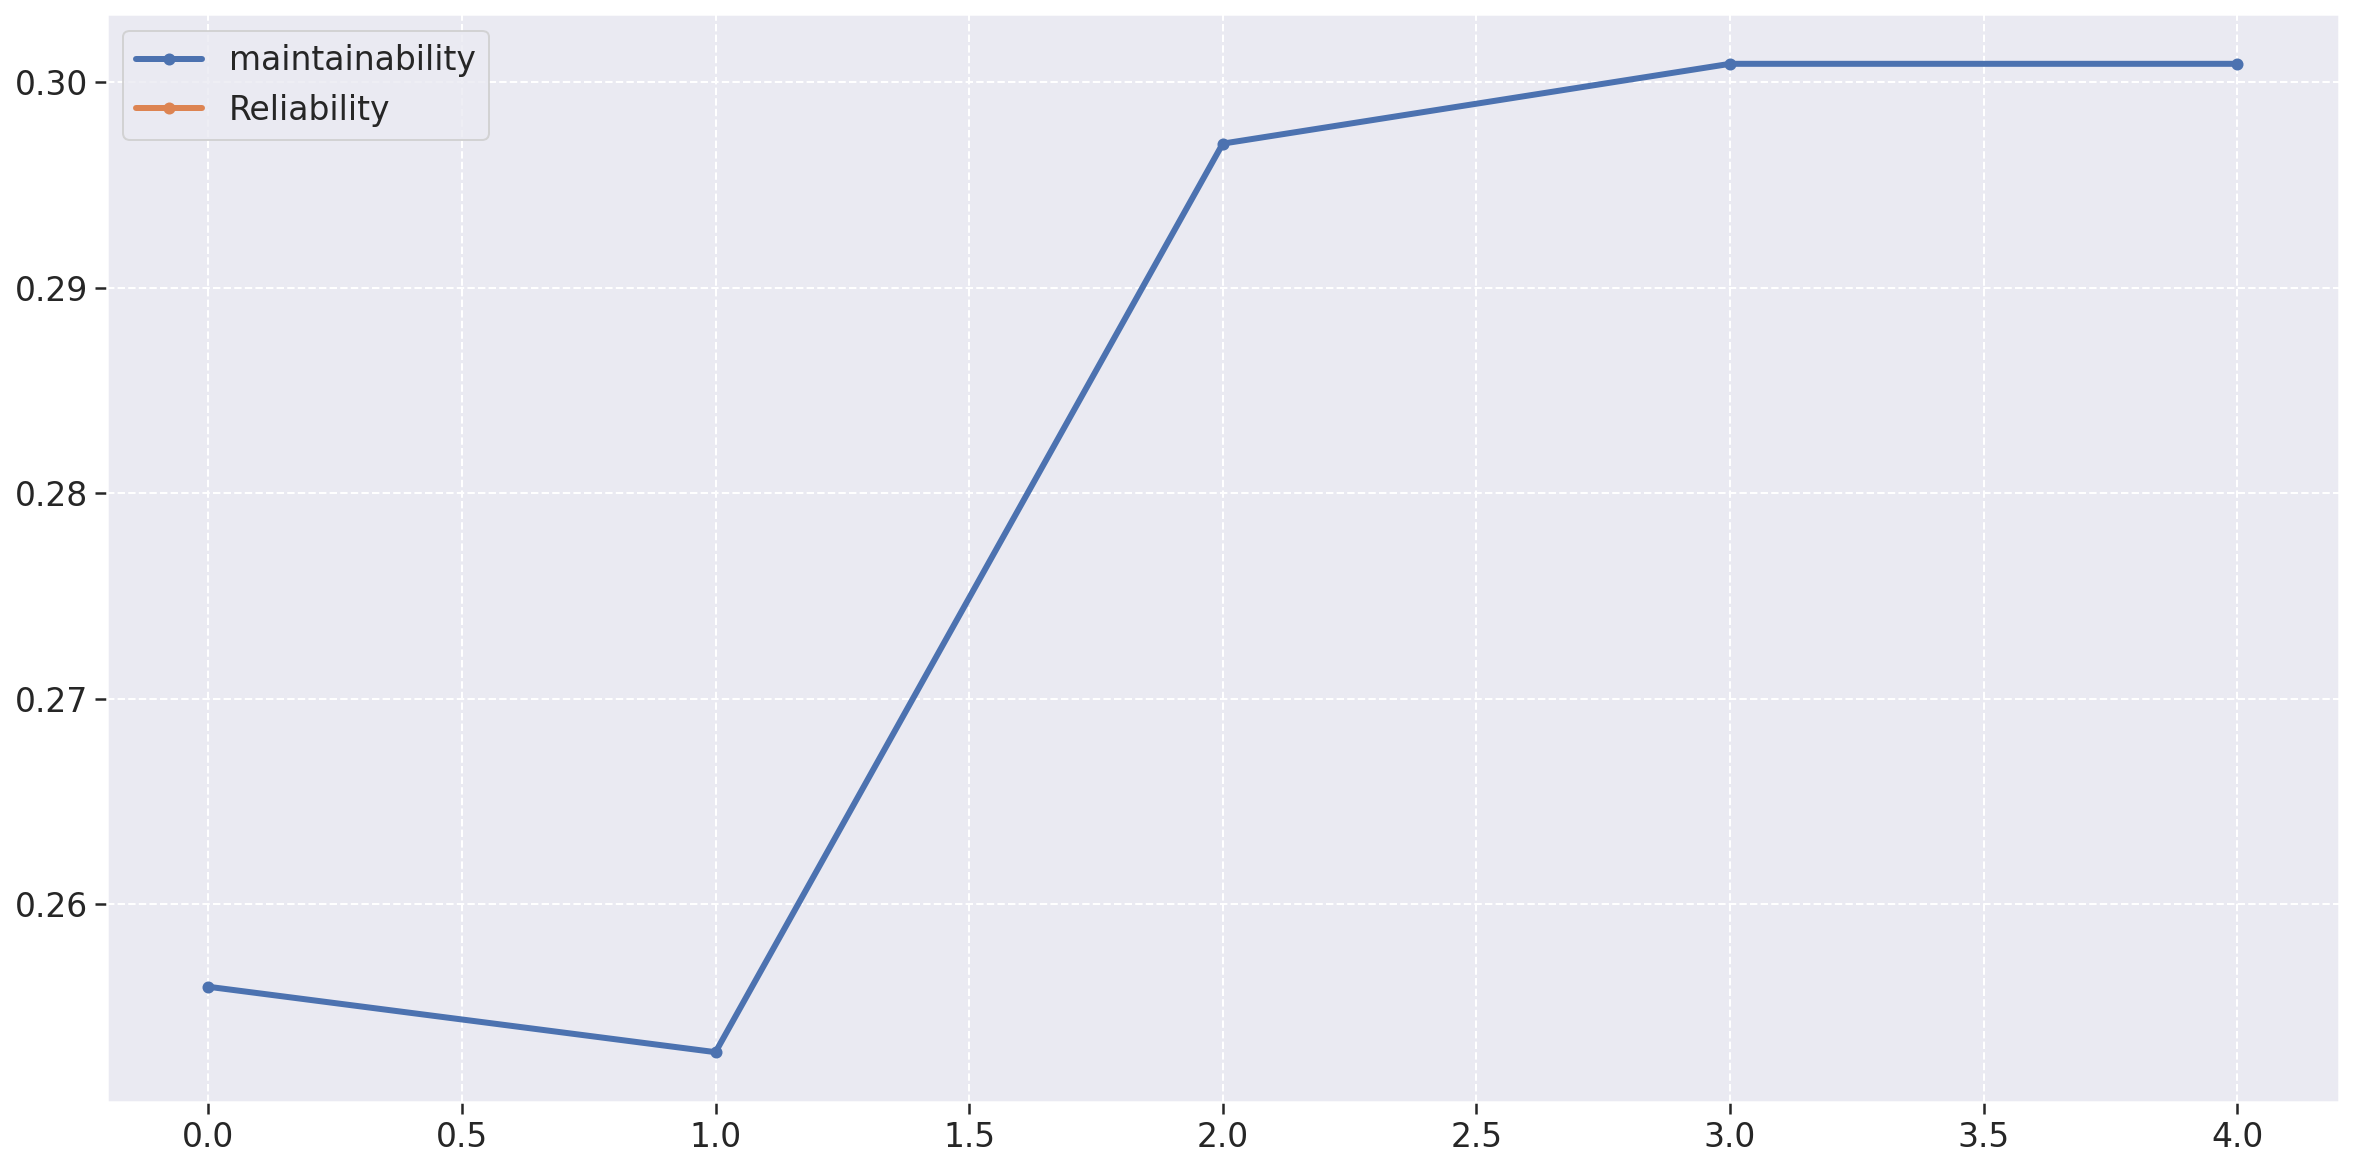

In [31]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['maintainability'], label='maintainability', linewidth=3, marker='o', markersize=5)
plt.plot(metrics_df['Reliability'], label='Reliability', linewidth=3, marker='o', markersize=5)

plt.legend(loc='upper left')

#plt.ylim(.45,.7)

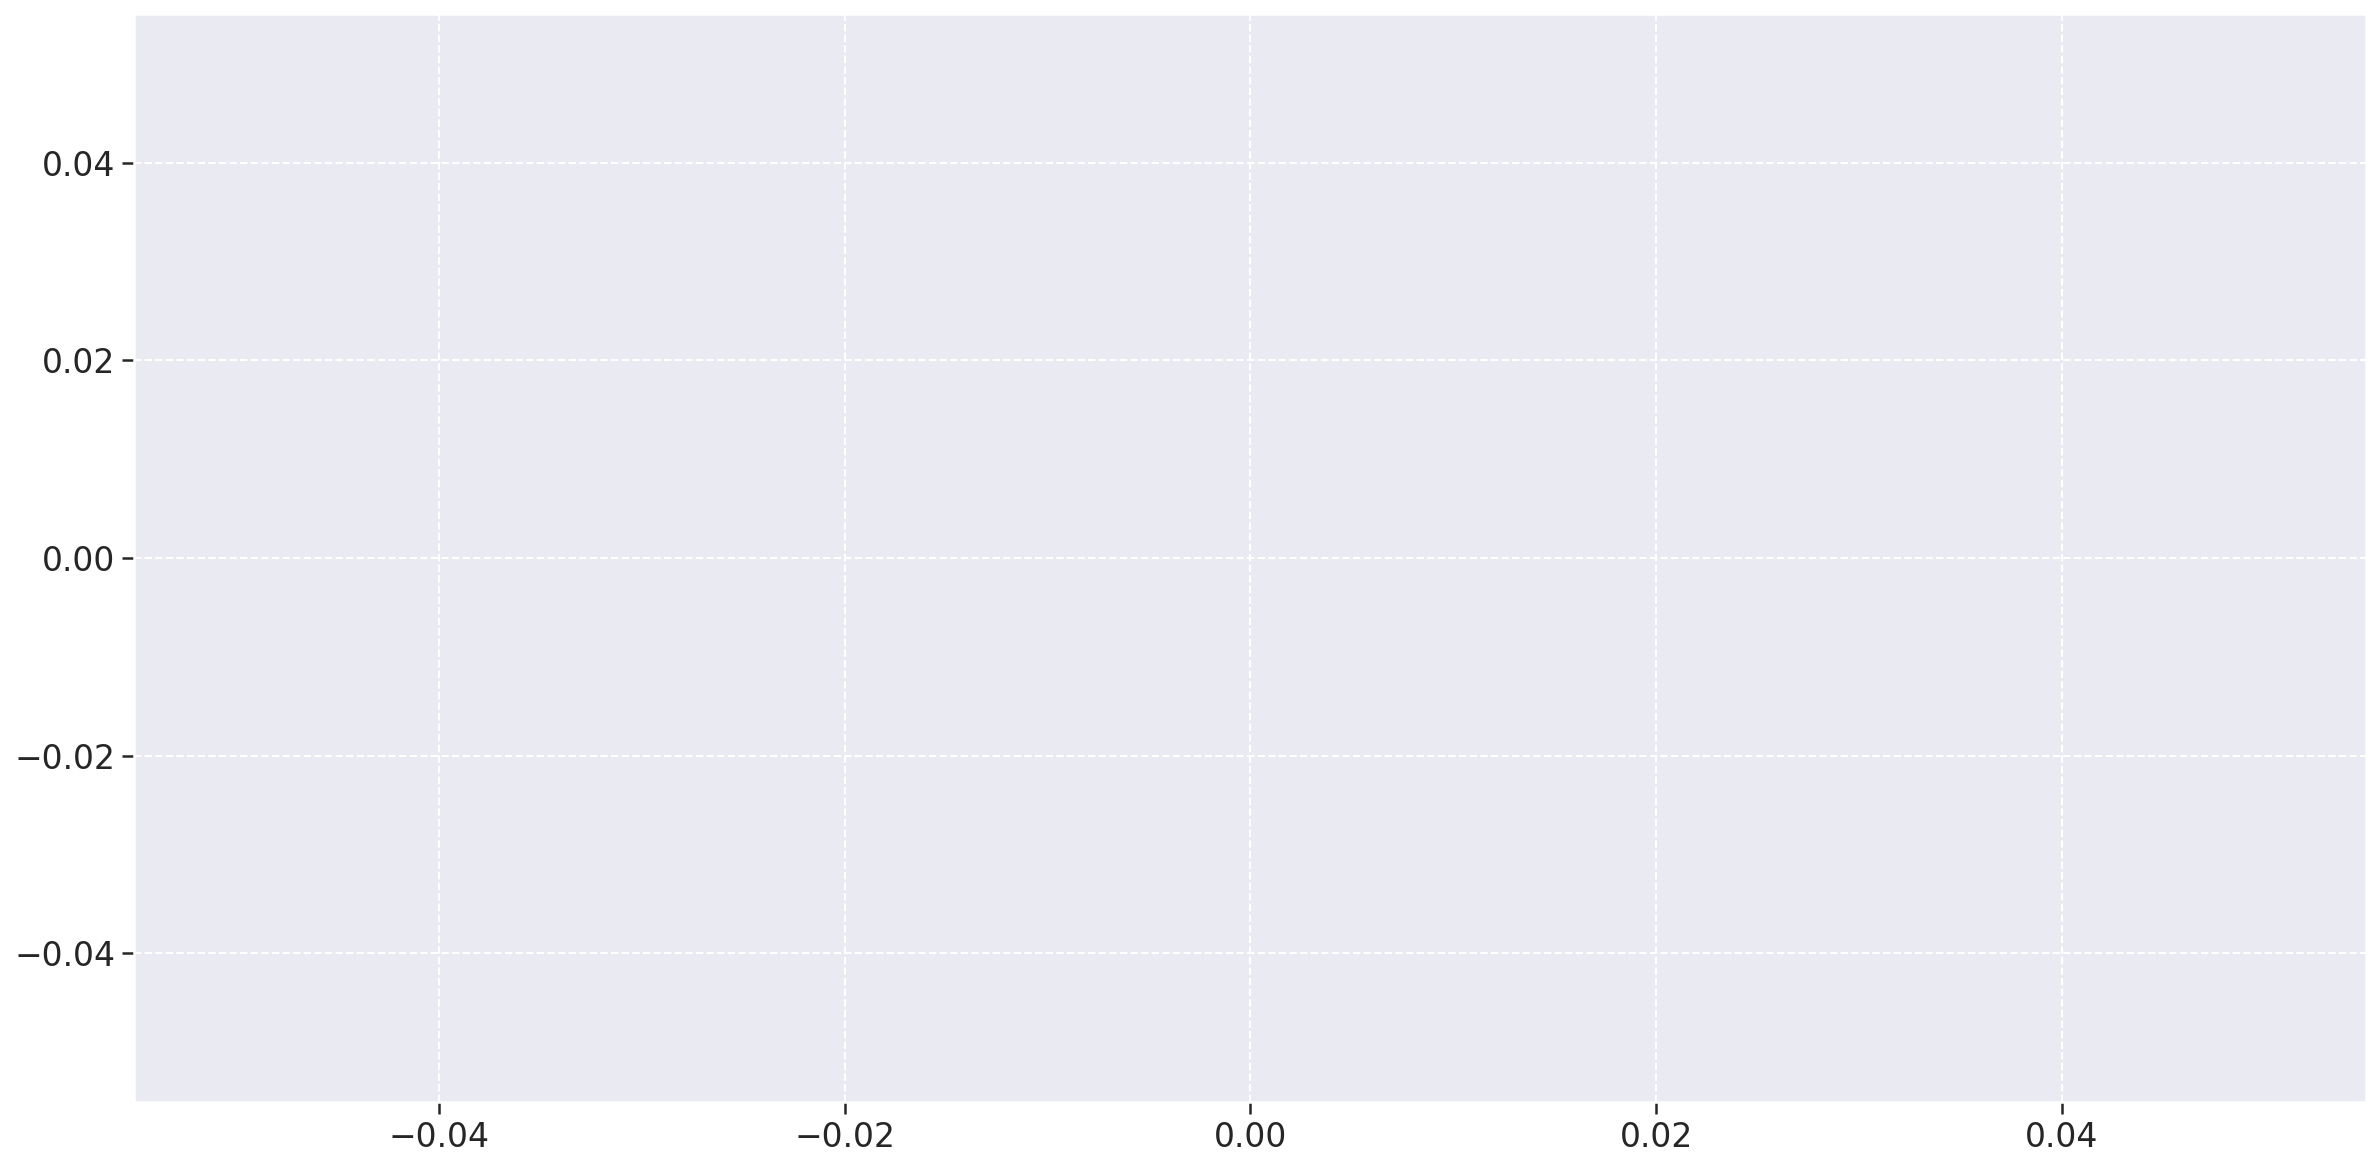

In [32]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)


#plt.ylim(.45,.7)


In [33]:
# ANALYSIS_DATE FORMAT: MM-DD-YYYY
from datetime import datetime

now = datetime.now()
now_str = now.strftime("%m-%d-%Y")

df = metrics_df[[
    'm1',
    'm2',
    'm3',
    'm4',
    'm5',
    'm6',
    'maintainability',
    'Reliability',
    'total',
    'ncloc',
    'repository',
    'version'
]].copy()
df['data'] = now_str

df.to_excel('data/fga-eps-mds-2021.2-Oraculo-DATASET-{}.xlsx'.format(now_str), index = False)
df.to_csv('data/fga-eps-mds-2021.2-Oraculo-DATASET-{}.csv'.format(now_str), index = False)

## Análise

### Funções Auxiliares

In [34]:
def element_or_list(x):
    return x[0] if len(x) == 1 else x

### Funções

In [35]:
def descriptive_statistics(**kwargs):

    data = {
        'média': [kwargs[key].mean() for key in kwargs],
        'moda': [element_or_list(kwargs[key].mode().values.tolist()) for key in kwargs],
        'mediana': [kwargs[key].median() for key in kwargs],
        'desvio padrão': [kwargs[key].std() for key in kwargs],
        'variância': [kwargs[key].var() for key in kwargs],
        'mínimo': [kwargs[key].min() for key in kwargs],
        'máximo': [kwargs[key].max() for key in kwargs]
    }
    
    return pd.DataFrame.from_dict(data, orient='index', columns=[key for key in kwargs])

In [36]:
def percentile(**kwargs):
    
    data = {
        '5th' : [kwargs[key].quantile(0.05) for key in kwargs],
        '10th': [kwargs[key].quantile(0.10) for key in kwargs],
        '25th': [kwargs[key].quantile(0.25) for key in kwargs],
        '50th': [kwargs[key].quantile(0.50) for key in kwargs],
        '75th': [kwargs[key].quantile(0.75) for key in kwargs],
        '90th': [kwargs[key].quantile(0.90) for key in kwargs],
        '95th': [kwargs[key].quantile(0.95) for key in kwargs],
        '99th': [kwargs[key].quantile(0.99) for key in kwargs],
    }
    
    return pd.DataFrame.from_dict(data, orient='index', columns=[key for key in kwargs])

In [37]:
def correlation_matrix(**kwargs):
    
    fig = plt.figure(figsize=(12, 8))

    data = {k:v for k,v in kwargs.items()}

    ax = plt.axes()
    sns.heatmap(pd.DataFrame.from_dict(data).corr(), square=True, linewidths=1, annot=True, ax = ax)
    ax.set_title('Matriz de Correlação')

In [38]:
def box_plot(maintainability, reliability):
    data = [
        maintainability,
        reliability
    ]
    
    fig, ax = plt.subplots()
    ax.boxplot(data, labels=['maintainability', 'reliability'])

In [39]:
def scatter(frontEnd, profile, registros):
    ax1 = frontEnd.plot(kind='scatter', x='code_quality', y='testing_status', color='r', label='front')
    ax2 = profile.plot(kind='scatter', x='code_quality', y='testing_status', color='g', label='profile', ax=ax1)
    ax3 = registros.plot(kind='scatter', x='code_quality', y='testing_status', color='b', label='registros', ax=ax1, xlabel='maintainability', ylabel='reliability', figsize=(8,6))

In [40]:
def histogram(total):
    fig = plt.figure(figsize=(20, 10))
    plt.hist(total, color='limegreen')
    plt.axvline(total.mean(), linestyle='dashed', color='black')

### FrontEnd

In [41]:
df = frontEnd_metrics.copy()

#### Maintainability

In [42]:
descriptive_statistics(
    complexity=df['m1'],
    comments=df['m2'],
    duplications=df['m3']
)

,complexity,comments,duplications
média,0.53241,0.03704,0.972306
moda,"[0.5321100917431193, 0.5327102803738317]","[0.03669724770642202, 0.037383177570093455]","[0.963302752293578, 0.9813084112149533]"
mediana,0.53241,0.03704,0.972306
desvio padrão,0.000424,0.000485,0.012732
variância,0.0,0.0,0.000162
mínimo,0.53211,0.036697,0.963303
máximo,0.53271,0.037383,0.981308


In [43]:
percentile(
    complexity=df['m1'],
    comments=df['m2'],
    duplications=df['m3']
)

,complexity,comments,duplications
5th,0.532140,0.036732,0.964203
10th,0.532170,0.036766,0.965103
25th,0.532260,0.036869,0.967804
50th,0.532410,0.037040,0.972306
75th,0.532560,0.037212,0.976807
90th,0.532650,0.037315,0.979508
95th,0.532680,0.037349,0.980408
99th,0.532704,0.037376,0.981128


#### Reliability

In [44]:
descriptive_statistics(
    passed_tests=df['m4'],
    fast_tests=df['m5'],
    test_coverage=df['m6']
)

/home/caio/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,passed_tests,fast_tests,test_coverage
média,1.0,NaN,0.374989
moda,1.0,[],"[0.37383177570093457, 0.3761467889908257]"
mediana,1.0,NaN,0.374989
desvio padrão,0.0,NaN,0.001637
variância,0.0,NaN,0.000003
mínimo,1.0,NaN,0.373832
máximo,1.0,NaN,0.376147


In [45]:
percentile(
    passed_tests=df['m4'],
    fast_tests=df['m5'],
    test_coverage=df['m6']
)

,passed_tests,fast_tests,test_coverage
5th,1.0,NaN,0.373948
10th,1.0,NaN,0.374063
25th,1.0,NaN,0.374411
50th,1.0,NaN,0.374989
75th,1.0,NaN,0.375568
90th,1.0,NaN,0.375915
95th,1.0,NaN,0.376031
99th,1.0,NaN,0.376124


#### Correlation Matrix

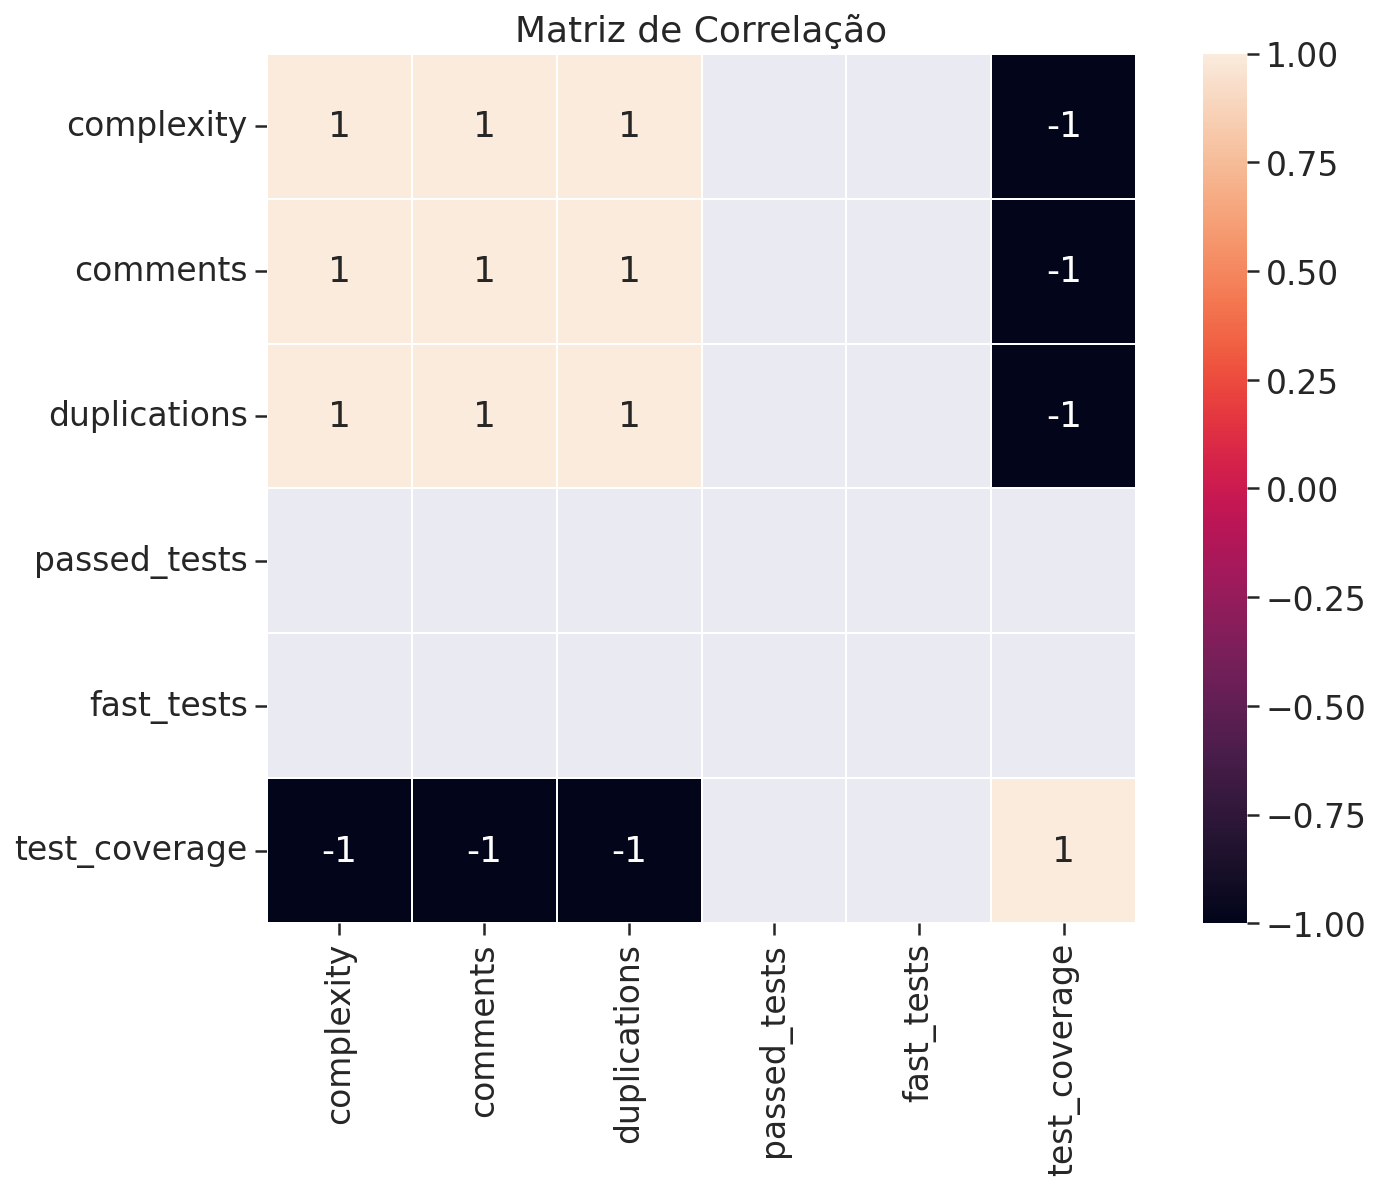

In [46]:
correlation_matrix(
    complexity=df['m1'],
    comments=df['m2'],
    duplications=df['m3'],
    passed_tests=df['m4'],
    fast_tests=df['m5'],
    test_coverage=df['m6'],
)

#### Box-Plot

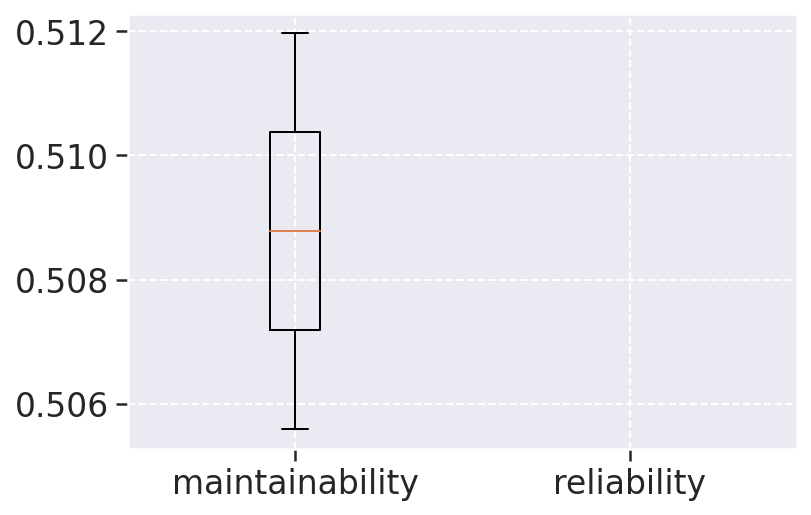

In [47]:
box_plot(df['code_quality'], df['testing_status'])

### Profile

In [48]:
df = profile_metrics.copy()

#### Maintainability

In [49]:
descriptive_statistics(
    complexity=df['m1'],
    comments=df['m2'],
    duplications=df['m3']
)

,complexity,comments,duplications
média,0.8,0.0,1.0
moda,0.8,0.0,1.0
mediana,0.8,0.0,1.0
desvio padrão,NaN,NaN,NaN
variância,NaN,NaN,NaN
mínimo,0.8,0.0,1.0
máximo,0.8,0.0,1.0


In [50]:
percentile(
    complexity=df['m1'],
    comments=df['m2'],
    duplications=df['m3']
)

,complexity,comments,duplications
5th,0.8,0.0,1.0
10th,0.8,0.0,1.0
25th,0.8,0.0,1.0
50th,0.8,0.0,1.0
75th,0.8,0.0,1.0
90th,0.8,0.0,1.0
95th,0.8,0.0,1.0
99th,0.8,0.0,1.0


#### Reliability

In [51]:
descriptive_statistics(
    passed_tests=df['m4'],
    fast_tests=df['m5'],
    test_coverage=df['m6']
)

/home/caio/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,passed_tests,fast_tests,test_coverage
média,1.0,NaN,1.0
moda,1.0,[],1.0
mediana,1.0,NaN,1.0
desvio padrão,NaN,NaN,NaN
variância,NaN,NaN,NaN
mínimo,1.0,NaN,1.0
máximo,1.0,NaN,1.0


In [52]:
percentile(
    passed_tests=df['m4'],
    fast_tests=df['m5'],
    test_coverage=df['m6']
)

,passed_tests,fast_tests,test_coverage
5th,1.0,NaN,1.0
10th,1.0,NaN,1.0
25th,1.0,NaN,1.0
50th,1.0,NaN,1.0
75th,1.0,NaN,1.0
90th,1.0,NaN,1.0
95th,1.0,NaN,1.0
99th,1.0,NaN,1.0


#### Correlation Matrix

/home/caio/.local/lib/python3.8/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/caio/.local/lib/python3.8/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


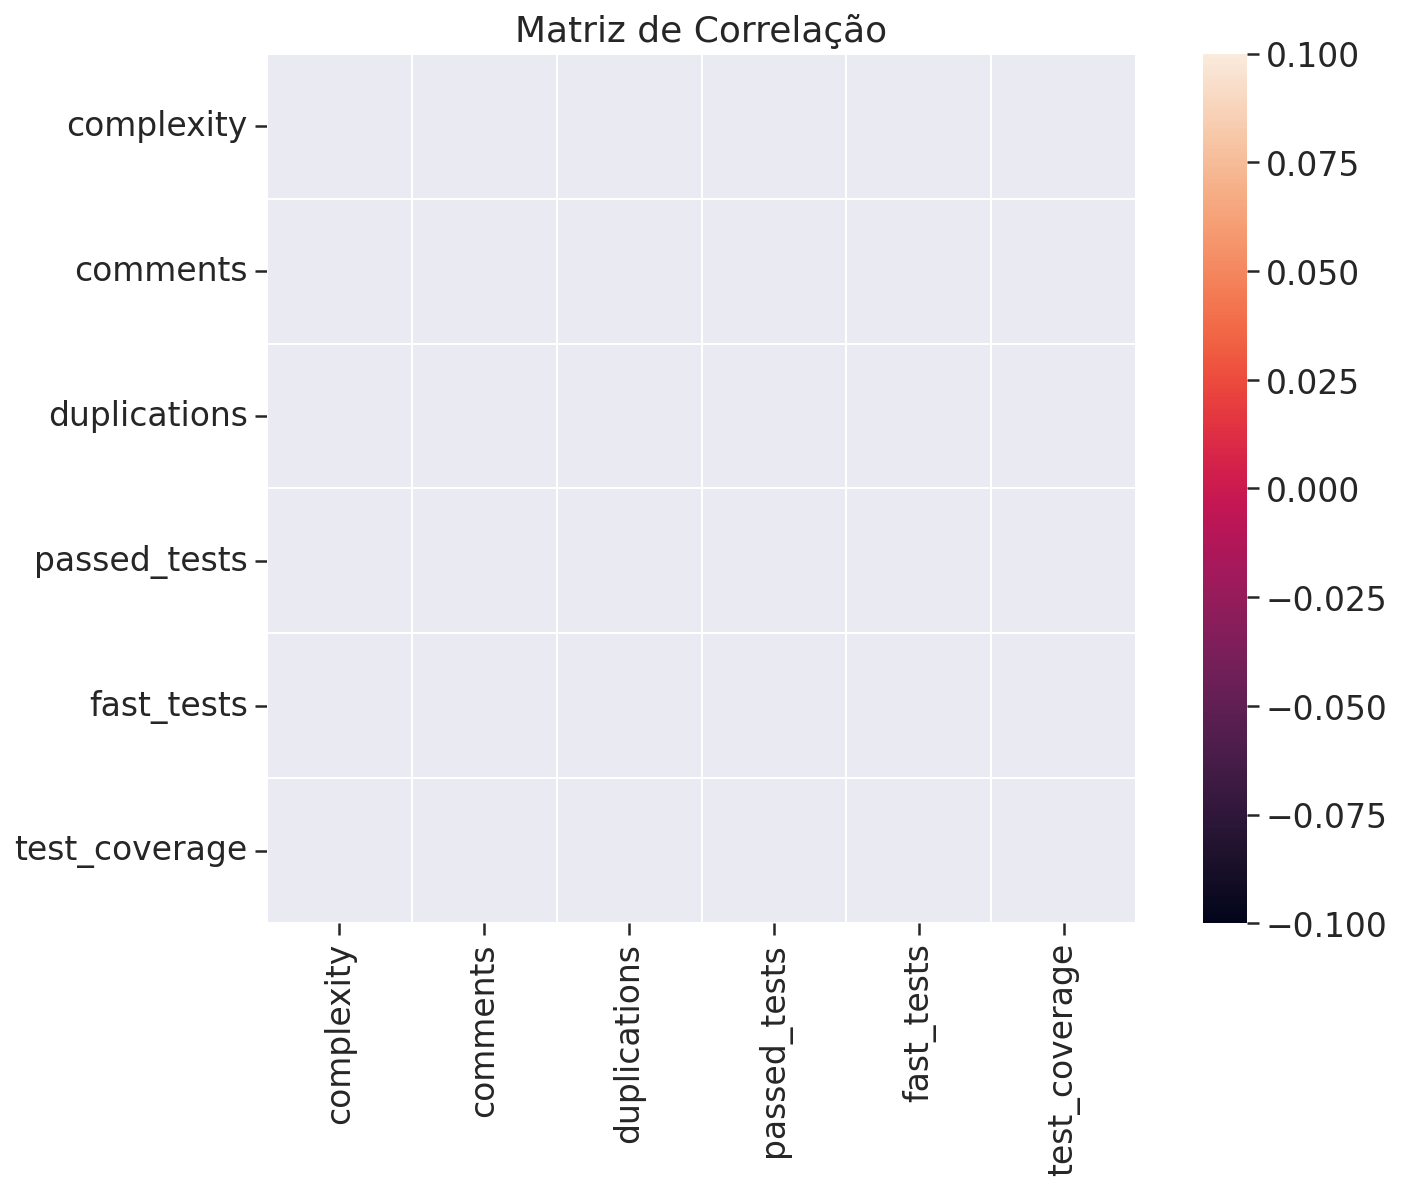

In [53]:
correlation_matrix(
    complexity=df['m1'],
    comments=df['m2'],
    duplications=df['m3'],
    passed_tests=df['m4'],
    fast_tests=df['m5'],
    test_coverage=df['m6'],
)

#### Box-Plot

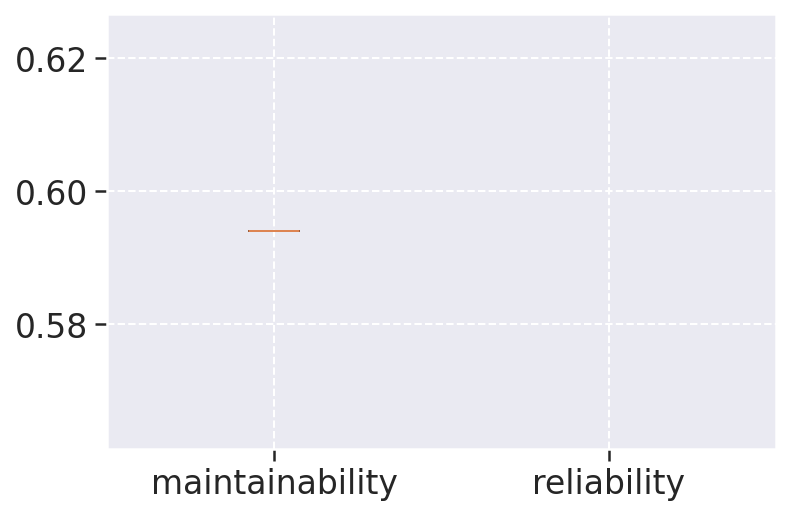

In [54]:
box_plot(df['code_quality'], df['testing_status'])

### Registros

In [55]:
df = registros_metrics.copy()

#### Maintainability

In [56]:
descriptive_statistics(
    complexity=df['m1'],
    comments=df['m2'],
    duplications=df['m3']
)

,complexity,comments,duplications
média,0.823529,0.0,1.0
moda,0.823529,0.0,1.0
mediana,0.823529,0.0,1.0
desvio padrão,0.000000,0.0,0.0
variância,0.000000,0.0,0.0
mínimo,0.823529,0.0,1.0
máximo,0.823529,0.0,1.0


In [57]:
percentile(
    complexity=df['m1'],
    comments=df['m2'],
    duplications=df['m3']
)

,complexity,comments,duplications
5th,0.823529,0.0,1.0
10th,0.823529,0.0,1.0
25th,0.823529,0.0,1.0
50th,0.823529,0.0,1.0
75th,0.823529,0.0,1.0
90th,0.823529,0.0,1.0
95th,0.823529,0.0,1.0
99th,0.823529,0.0,1.0


#### Reliability

In [58]:
descriptive_statistics(
    passed_tests=df['m4'],
    fast_tests=df['m5'],
    test_coverage=df['m6']
)

/home/caio/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,passed_tests,fast_tests,test_coverage
média,1.0,NaN,1.0
moda,1.0,[],1.0
mediana,1.0,NaN,1.0
desvio padrão,0.0,NaN,0.0
variância,0.0,NaN,0.0
mínimo,1.0,NaN,1.0
máximo,1.0,NaN,1.0


In [59]:
percentile(
    passed_tests=df['m4'],
    fast_tests=df['m5'],
    test_coverage=df['m6']
)

,passed_tests,fast_tests,test_coverage
5th,1.0,NaN,1.0
10th,1.0,NaN,1.0
25th,1.0,NaN,1.0
50th,1.0,NaN,1.0
75th,1.0,NaN,1.0
90th,1.0,NaN,1.0
95th,1.0,NaN,1.0
99th,1.0,NaN,1.0


#### Correlation Matrix

/home/caio/.local/lib/python3.8/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/caio/.local/lib/python3.8/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


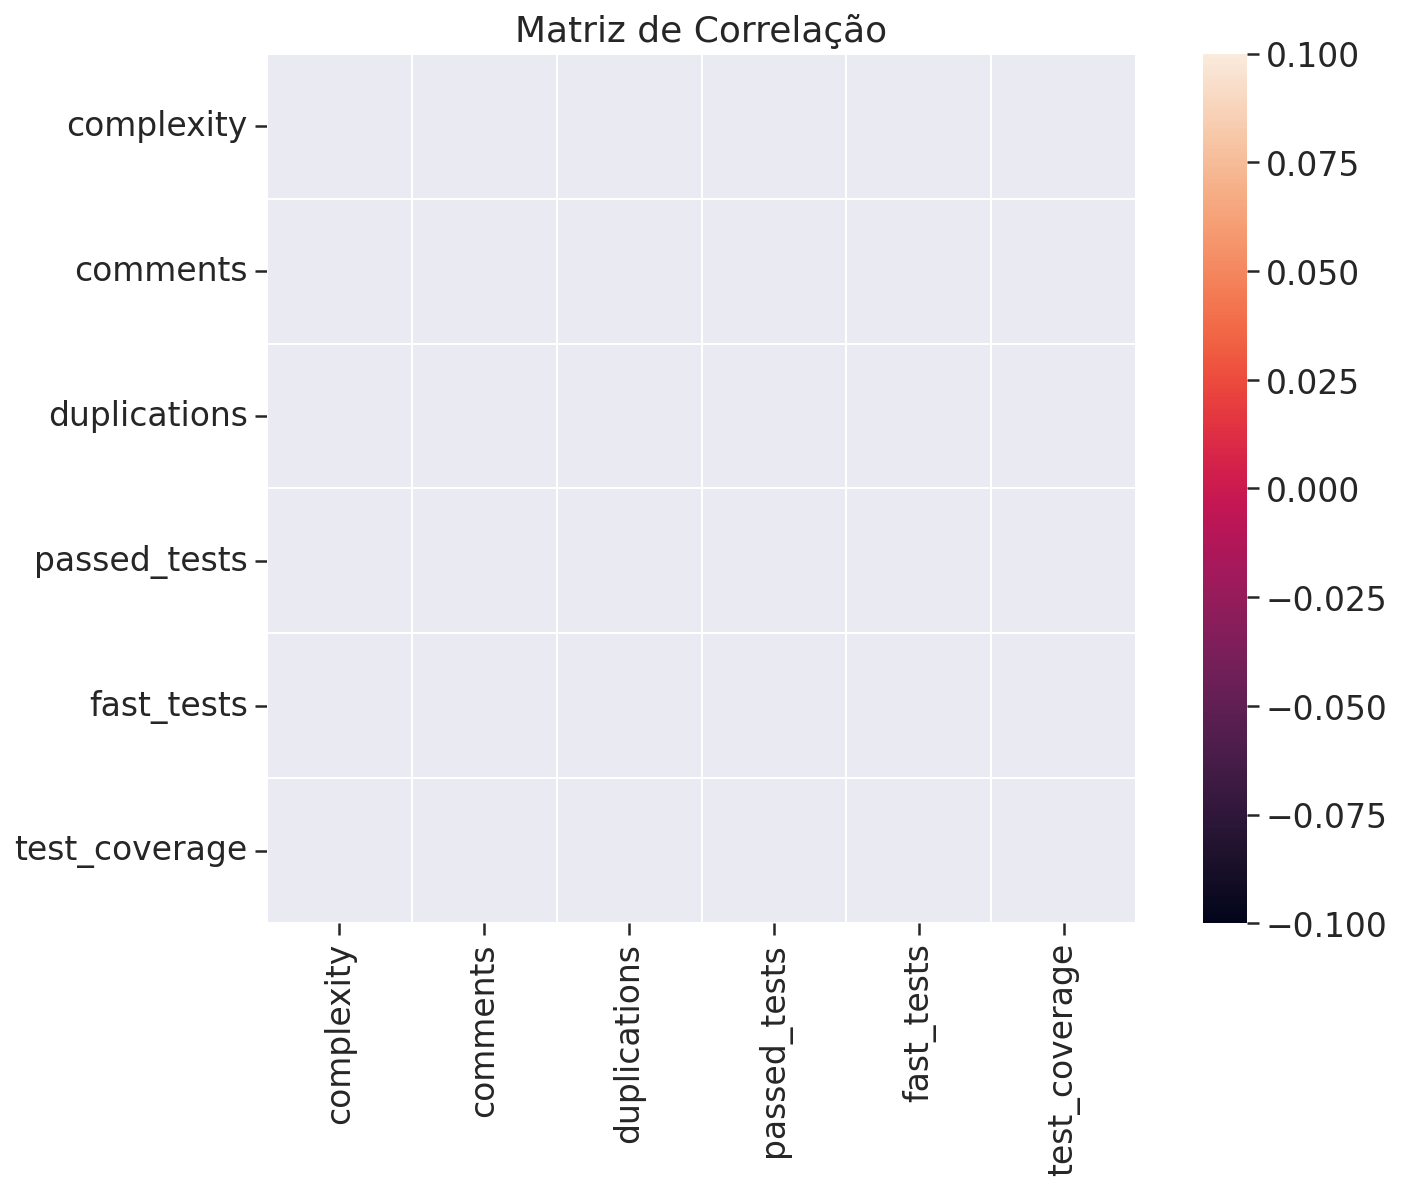

In [60]:
correlation_matrix(
    complexity=df['m1'],
    comments=df['m2'],
    duplications=df['m3'],
    passed_tests=df['m4'],
    fast_tests=df['m5'],
    test_coverage=df['m6'],
)

#### Box-Plot

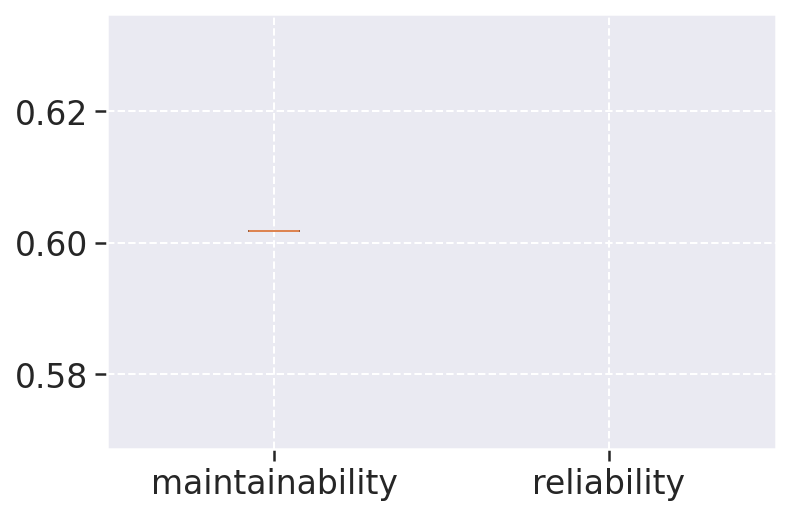

In [61]:
box_plot(df['code_quality'], df['testing_status'])

### Total

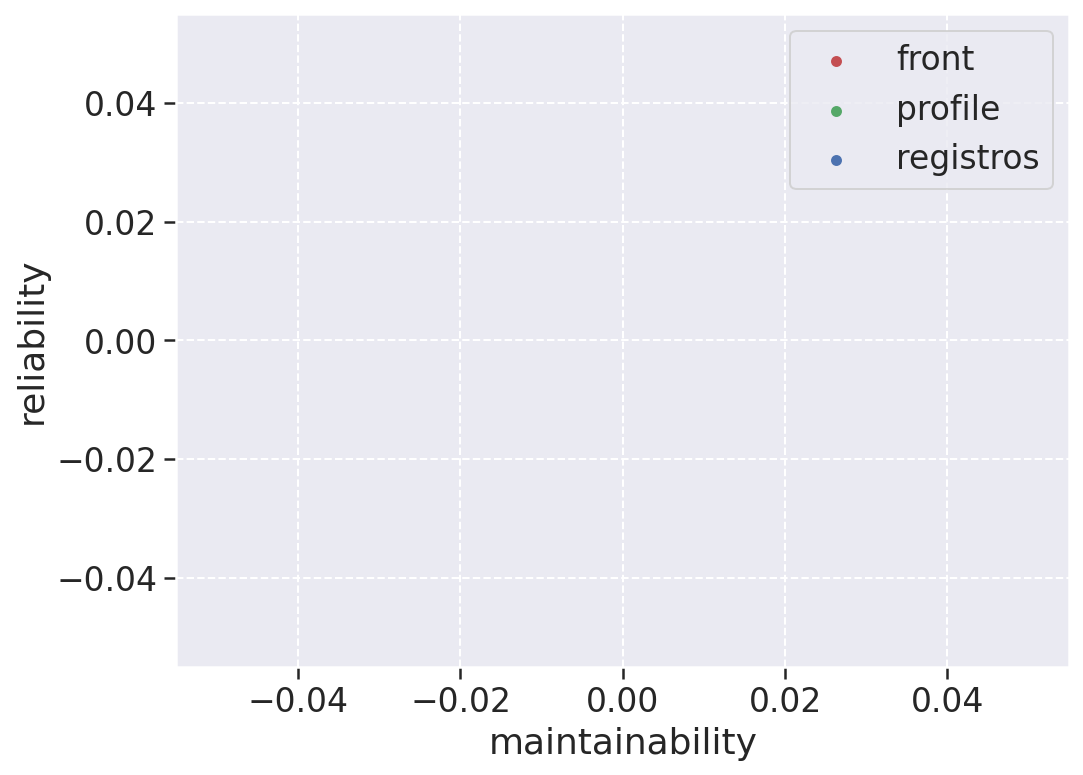

In [62]:
scatter(
    frontEnd_metrics,
    profile_metrics,
    registros_metrics,
)

/home/caio/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6611: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/caio/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6612: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

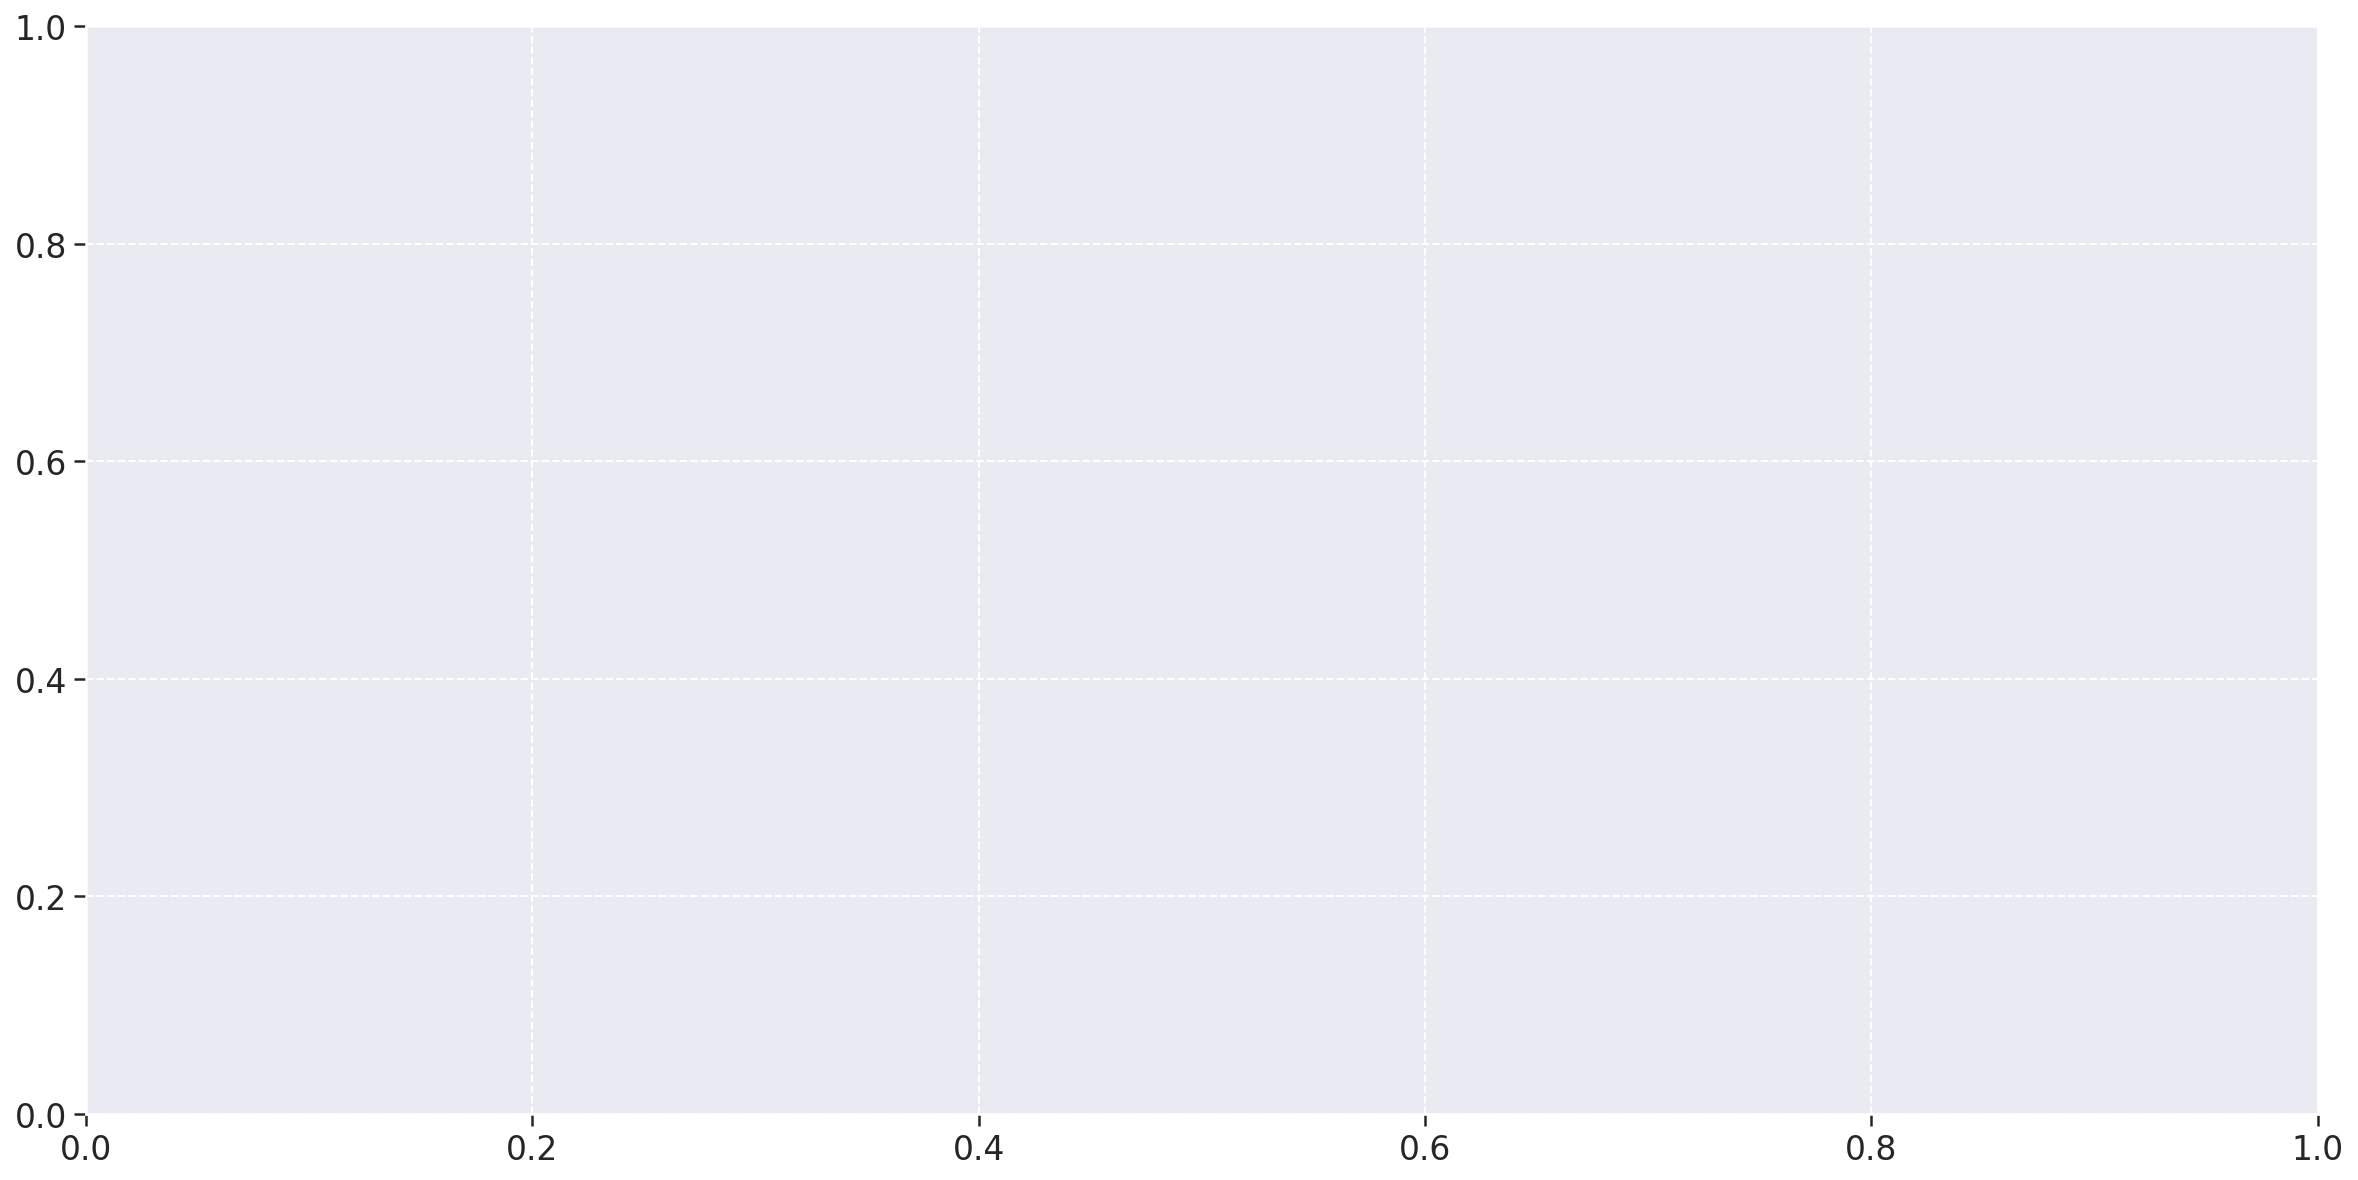

In [63]:
histogram(metrics_df['total'])

#### Análise

##### Reliability

Para o aspecto de qualidade de reliability, a equipe conseguiu manter resultados razoáveis para o repositório de frontend e excelentes resultados para os microsserviços.

Por conta da dificuldade em testar o código desenvolvido no frontend, os valores para essa medida se manteram entre 0.5 e 0.6 durante a maior parte da vida do projeto. Como é possível ver na tabela de estatística descritiva, a cobertura de teste teve valores abaixo do aceitável (60%) para a maior parte dos arquivos e houve pequena mudança desse valor ao longo do desenvolvimento do projeto, evidenciando a dificuldade do grupo em testar o código.

Já para os microsserviços, que foi mais fácil de realizar os testes, teve resultados excelentes durante todo o tempo de desenvolvimento do projeto. A equipe foi capaz de criar testes com altas taxas de cobertura para os dois microsserviços.

##### Maintainability

Para o aspecto de qualidade de maintainability, a equipe conseguiu resultados razoáveis durante todo o desenvolvimento do projeto em todos os repositórios.

Tanto no frontend quanto nos microsserviços de profile e registros, uma evidente maneira de melhorar a manutenibilidade dos códigos é escrevendo mais comentários. O grupo foi muito mal nesse aspecto, impactanto negativamente a manutenibilidade dos repositórios.

A complexidade dos arquivos dos microsserviços se mostrou baixa, evidenciado pelo seus valores altos (acima de 0.8 durante a maior parte do desenvolvimento). Já o frontend teve resultados razoáveis (quase 0.5) durante boa parte do desenvolvimento. Esses valores mostram que o grupo teve mais facilidade em seguir boas práticas de desenvolvimento nos microsserviços, em comparação ao frontend.

##### Total

Como é possível ver pelo histograma, para o indicador da qualidade total do produto, o valor se manteve próximo a 0.8 na maior parte do tempo de desenvolvimento do projeto. Esses valores são referentes aos microsserviços de profile e registros. Esse valor é devido aos excelentes resultados adquiridos pelos testes nos microsserviços, além de bons resultados nas métricas de manutenibilidade (com exceção da métrica de densidade de comentários).

Os valores próximos de 0.5 são do repositório de frontend. Ao longo do desenvolvimento do frontend o indicador da qualidade total variou pouco, pois os mesmos acertos (poucas duplicações e testes rápidos) e os mesmos erros (poucos comentários e baixa cobertura de teste) se manteram ao longo do desenvolvimento.